# EnAppSys Dataset - A Time Series and Regression Analysis

### To create a Electricity Demand forecast for France on an hourly level up to 48 hours ahead

In [1]:
#Importing necessary Libraries

import numpy as np
import pandas as pd


#Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Plots

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
import statsmodels.api as sm

In [3]:
#Modelling

from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [4]:
#Forecasting

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [5]:
# Data Download
df = pd.read_csv("dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45432 entries, 0 to 45431
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Time                         45432 non-null  object 
 1   demand                       45429 non-null  float64
 2   solar_actual(MW)             45413 non-null  float64
 3   solar_forecast(MW)           45210 non-null  float64
 4   solar_inferred_capacity(MW)  45432 non-null  float64
 5   wind_actual(MW)              45413 non-null  float64
 6   wind_inferred_capacity(MW)   45432 non-null  float64
 7   albedo(%)                    45415 non-null  float64
 8   cloud_cover(%)               45416 non-null  float64
 9   frozen_precipitation(%)      45422 non-null  float64
 10  pressure(Pa)                 45421 non-null  float64
 11  radiation(W/m2)              45416 non-null  float64
 12  air_tmp(Kelvin)              45422 non-null  float64
 13  ground_tmp(Kelvi

In [6]:
data = df.fillna(df.mean())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45432 entries, 0 to 45431
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Time                         45432 non-null  object 
 1   demand                       45432 non-null  float64
 2   solar_actual(MW)             45432 non-null  float64
 3   solar_forecast(MW)           45432 non-null  float64
 4   solar_inferred_capacity(MW)  45432 non-null  float64
 5   wind_actual(MW)              45432 non-null  float64
 6   wind_inferred_capacity(MW)   45432 non-null  float64
 7   albedo(%)                    45432 non-null  float64
 8   cloud_cover(%)               45432 non-null  float64
 9   frozen_precipitation(%)      45432 non-null  float64
 10  pressure(Pa)                 45432 non-null  float64
 11  radiation(W/m2)              45432 non-null  float64
 12  air_tmp(Kelvin)              45432 non-null  float64
 13  ground_tmp(Kelvi

In [7]:
data.head()

,Time,demand,solar_actual(MW),solar_forecast(MW),solar_inferred_capacity(MW),wind_actual(MW),wind_inferred_capacity(MW),albedo(%),cloud_cover(%),frozen_precipitation(%),pressure(Pa),radiation(W/m2),air_tmp(Kelvin),ground_tmp(Kelvin),apparent_tmp(Kelvin),wind_direction(angle),wind_speed(m/s),Day_of_the_week
0,2017-01-01 00:00:00+01:00,76345.25,0.0,1278.808883,5756.44,597.50,10513.95,0.0,2.45,-3.80,102875.0,0.0,271.60,269.82,269.84,209.0,2.97,Weekend
1,2017-01-01 01:00:00+01:00,75437.00,0.0,1278.808883,5756.44,597.50,10513.95,0.0,2.48,-3.46,102839.0,0.0,271.62,269.85,269.79,212.0,3.13,Weekend
2,2017-01-01 02:00:00+01:00,73368.25,0.0,1278.808883,5756.44,635.25,10513.95,0.0,4.62,-5.48,102735.0,0.0,271.61,269.93,269.58,218.0,3.25,Weekend
3,2017-01-01 03:00:00+01:00,72116.00,0.0,1278.808883,5756.44,628.50,10513.95,0.0,6.13,-6.91,102660.0,0.0,271.60,269.99,269.44,218.0,3.37,Weekend
4,2017-01-01 04:00:00+01:00,68593.75,0.0,1278.808883,5756.44,608.50,10513.95,0.0,6.75,-7.50,102629.0,0.0,271.60,270.02,269.38,219.0,3.42,Weekend


In [8]:
data.tail()

,Time,demand,solar_actual(MW),solar_forecast(MW),solar_inferred_capacity(MW),wind_actual(MW),wind_inferred_capacity(MW),albedo(%),cloud_cover(%),frozen_precipitation(%),pressure(Pa),radiation(W/m2),air_tmp(Kelvin),ground_tmp(Kelvin),apparent_tmp(Kelvin),wind_direction(angle),wind_speed(m/s),Day_of_the_week
45427,2022-03-08 19:00:00+01:00,69881.25,170.00,250.16,11244.01,4149.50,16116.79,15.56,56.09,-42.02,101826.0,272.42,278.71,277.30,276.89,175.0,5.08,Weekday
45428,2022-03-08 20:00:00+01:00,67759.00,166.25,130.32,11244.01,5012.75,16116.79,0.44,55.01,-43.17,101896.0,0.00,278.01,276.74,276.17,172.0,4.90,Weekday
45429,2022-03-08 21:00:00+01:00,64427.50,169.25,130.32,11244.01,5223.00,16116.79,0.44,47.87,-44.17,101954.0,0.00,277.60,276.40,275.72,173.0,4.80,Weekday
45430,2022-03-08 22:00:00+01:00,63364.25,165.50,134.79,11244.01,5200.75,16116.79,0.44,43.63,-45.54,102006.0,0.00,277.25,276.11,275.32,179.0,4.68,Weekday
45431,2022-03-08 23:00:00+01:00,63996.50,168.25,133.64,11244.01,5013.00,16116.79,0.44,40.18,-45.92,102044.0,0.00,276.92,275.77,274.99,182.0,4.57,Weekday


In [9]:
data.isnull().sum()

Time                           0
demand                         0
solar_actual(MW)               0
solar_forecast(MW)             0
solar_inferred_capacity(MW)    0
wind_actual(MW)                0
wind_inferred_capacity(MW)     0
albedo(%)                      0
cloud_cover(%)                 0
frozen_precipitation(%)        0
pressure(Pa)                   0
radiation(W/m2)                0
air_tmp(Kelvin)                0
ground_tmp(Kelvin)             0
apparent_tmp(Kelvin)           0
wind_direction(angle)          0
wind_speed(m/s)                0
Day_of_the_week                0
dtype: int64

In [10]:
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


## Univariate analysis

Weekday    32448
Weekend    12984
Name: Day_of_the_week, dtype: int64


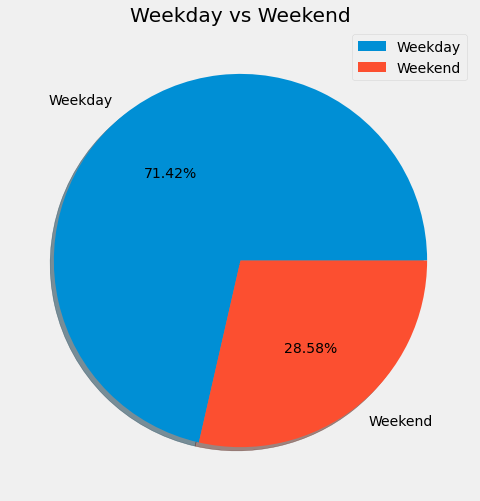

In [11]:
print(data['Day_of_the_week'].value_counts())
plt.figure(figsize = (8,8))
plt.pie(data['Day_of_the_week'].value_counts(), labels = ['Weekday','Weekend'], autopct='%.2f%%',  shadow = True)
plt.title('Weekday vs Weekend')
plt.legend()
plt.show()

#### Insights : We see that the number of Weekdays is 71.42% compared to 28.58%. The data for both are significant enough and trends are analyzed on the electricity demand for these days.

#### Column : solar _actual(MW) and solar_forecast(MW)

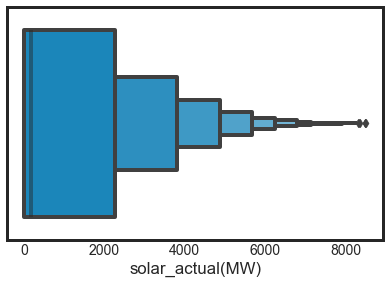

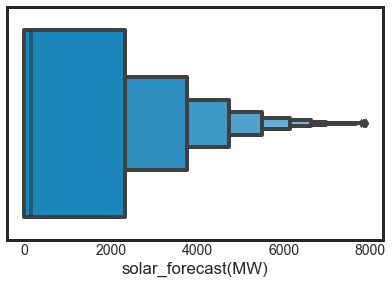

count    45432.000000
mean      1286.331384
std       1782.357664
min          0.000000
25%          0.000000
50%        175.750000
75%       2259.875000
max       8511.750000
Name: solar_actual(MW), dtype: float64

In [12]:
sns.set_style("ticks")
res= sns.boxenplot(data['solar_actual(MW)'])
plt.show()


sns.set_style("ticks")
res= sns.boxenplot(data['solar_forecast(MW)'])
plt.show()

data['solar_actual(MW)'].describe()

In [13]:
data['solar_forecast(MW)'].describe()

count    45432.000000
mean      1278.808883
std       1757.037316
min          0.000000
25%          0.000000
50%        162.315000
75%       2323.780000
max       7900.170000
Name: solar_forecast(MW), dtype: float64

#### Column : solar_inferred_capacity(MW)

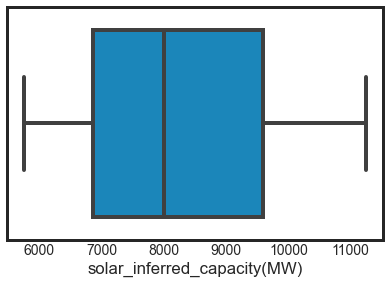

count    45432.000000
mean      8255.743000
std       1616.991295
min       5756.440000
25%       6864.480000
50%       7992.890000
75%       9595.960000
max      11244.010000
Name: solar_inferred_capacity(MW), dtype: float64

In [14]:
sns.set_style("ticks")
res= sns.boxplot(data['solar_inferred_capacity(MW)'])
plt.show()
data['solar_inferred_capacity(MW)'].describe()

#### Column : wind_actual(MW)

count    45432.000000
mean      3614.698500
std       2707.828851
min        391.000000
25%       1584.000000
50%       2714.250000
75%       4921.750000
max      14475.750000
Name: wind_actual(MW), dtype: float64

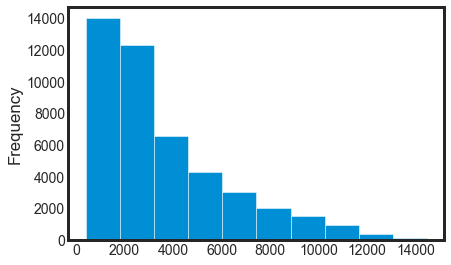

In [15]:
data['wind_actual(MW)'].plot(kind = 'hist')
data['wind_actual(MW)'].describe()

#### Column : solar_inferred_capacity(MW)

count    45432.000000
mean     14319.562303
std       1850.099922
min      10494.090000
25%      12256.000000
50%      15009.340000
75%      15985.940000
max      16116.790000
Name: wind_inferred_capacity(MW), dtype: float64

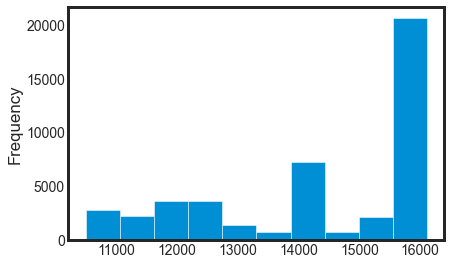

In [16]:
data['wind_inferred_capacity(MW)'].plot(kind = 'hist')
data['wind_inferred_capacity(MW)'].describe()

#### Column : albedo(%)

count    45432.000000
mean        11.157362
std          8.474611
min          0.000000
25%          0.000000
50%         14.750000
75%         17.180000
max         31.550000
Name: albedo(%), dtype: float64

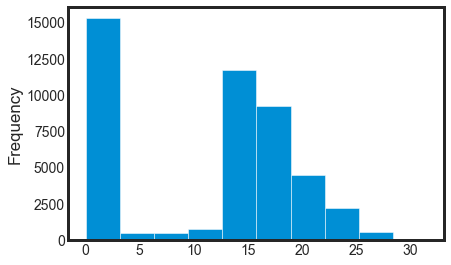

In [17]:
#Analyzing albedo[%]

data['albedo(%)'].plot(kind = 'hist')
data['albedo(%)'].describe()

#### Column : cloud_cover(%)

count    45432.000000
mean        55.270664
std         25.875061
min          0.000000
25%         34.767500
50%         57.820000
75%         76.952500
max         99.940000
Name: cloud_cover(%), dtype: float64

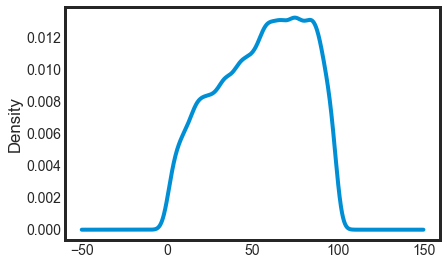

In [18]:
sns.set_style('ticks')
data['cloud_cover(%)'].plot(kind = 'density')
data['cloud_cover(%)'].describe()


#### frozen_precipitation(%)

<AxesSubplot:ylabel='Density'>

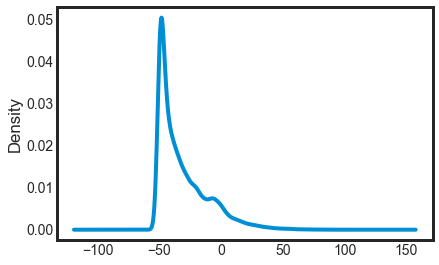

In [19]:
sns.set_style('ticks')
data['frozen_precipitation(%)'].plot(kind = 'density')

#### Column : pressure(Pa)

<AxesSubplot:xlabel='pressure(Pa)'>

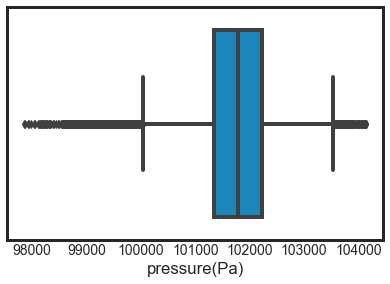

In [20]:
#Analyzing pressure(Pa)

data['pressure(Pa)'].describe()

sns.set_style("ticks")
sns.boxplot(data['pressure(Pa)'])

#### Column : radiation(W/m2)

count    45432.000000
mean       160.796661
std        220.388032
min          0.000000
25%          0.000000
50%         26.580000
75%        280.372500
max        916.430000
Name: radiation(W/m2), dtype: float64

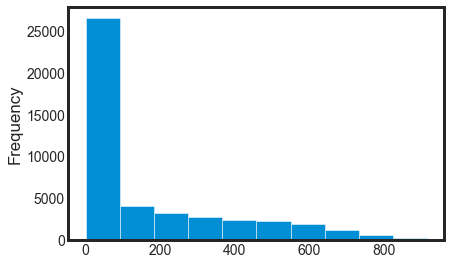

In [21]:
#Analyzing radiation(W/m2)

data['radiation(W/m2)'].plot(kind = 'hist')
data['radiation(W/m2)'].describe()

#### Column : air_tmp(Kelvin)

count    45432.000000
mean       284.324071
std          6.848991
min        265.340000
25%        279.120000
50%        283.640000
75%        289.010000
max        308.000000
Name: air_tmp(Kelvin), dtype: float64

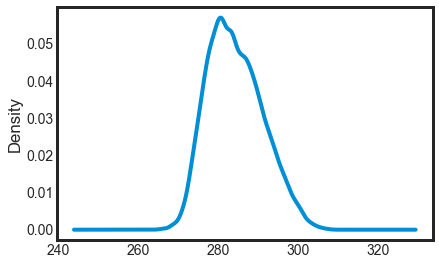

In [22]:
#Analyzing air_tmp(Kelvin)
data['air_tmp(Kelvin)'].plot(kind = 'density')
data['air_tmp(Kelvin)'].describe()

#### Column : ground_tmp(Kelvin)

count    45432.000000
mean       284.243751
std          7.472448
min        265.250000
25%        278.600000
50%        283.390000
75%        288.970000
max        310.320000
Name: ground_tmp(Kelvin), dtype: float64

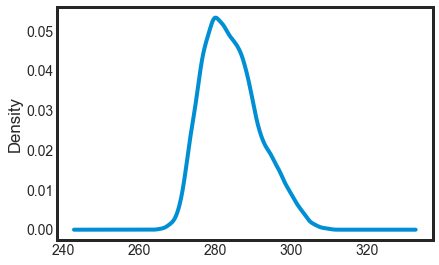

In [23]:
#Analyzing ground_tmp(Kelvin)
data['ground_tmp(Kelvin)'].plot(kind = 'density')
data['ground_tmp(Kelvin)'].describe()

#### Column : apparent_tmp(Kelvin)

count    45432.000000
mean       283.262665
std          7.856201
min        259.800000
25%        277.070000
50%        283.050000
75%        288.980000
max        308.370000
Name: apparent_tmp(Kelvin), dtype: float64

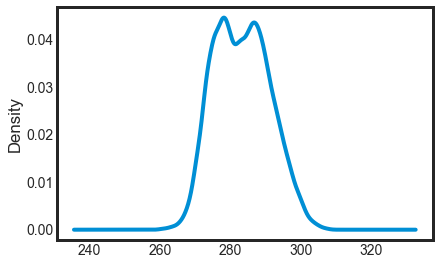

In [24]:
#Analyzing apparent_tmp(Kelvin)

data['apparent_tmp(Kelvin)'].plot(kind = 'density')
data['apparent_tmp(Kelvin)'].describe()

#### Column : wind_direction(angle)

count    45432.000000
mean       190.253429
std         59.920524
min         50.000000
25%        141.000000
50%        193.000000
75%        240.000000
max        325.000000
Name: wind_direction(angle), dtype: float64

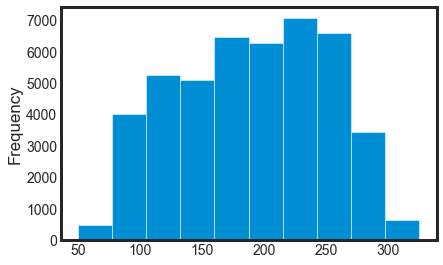

In [25]:
#Analyzing wind_direction(angle)

data['wind_direction(angle)'].plot(kind = 'hist')
data['wind_direction(angle)'].describe()

#### Column : wind_speed(m/s)

count    45432.000000
mean         5.615327
std          2.156225
min          1.270000
25%          4.070000
50%          5.220000
75%          6.720000
max         16.930000
Name: wind_speed(m/s), dtype: float64

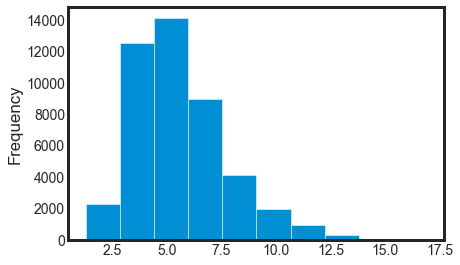

In [26]:
#Analyzing wind_speed(m/s)

data['wind_speed(m/s)'].plot(kind = 'hist')
data['wind_speed(m/s)'].describe()

# MultiVariate Analysis

## Analysing Columns against Datetime column

In [27]:
type(data.Time[0])

str

In [28]:
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index('Time')
data = data.asfreq('60min')
data = data.sort_index()
data.head(2)

extra = data.copy()

<AxesSubplot:xlabel='Time'>

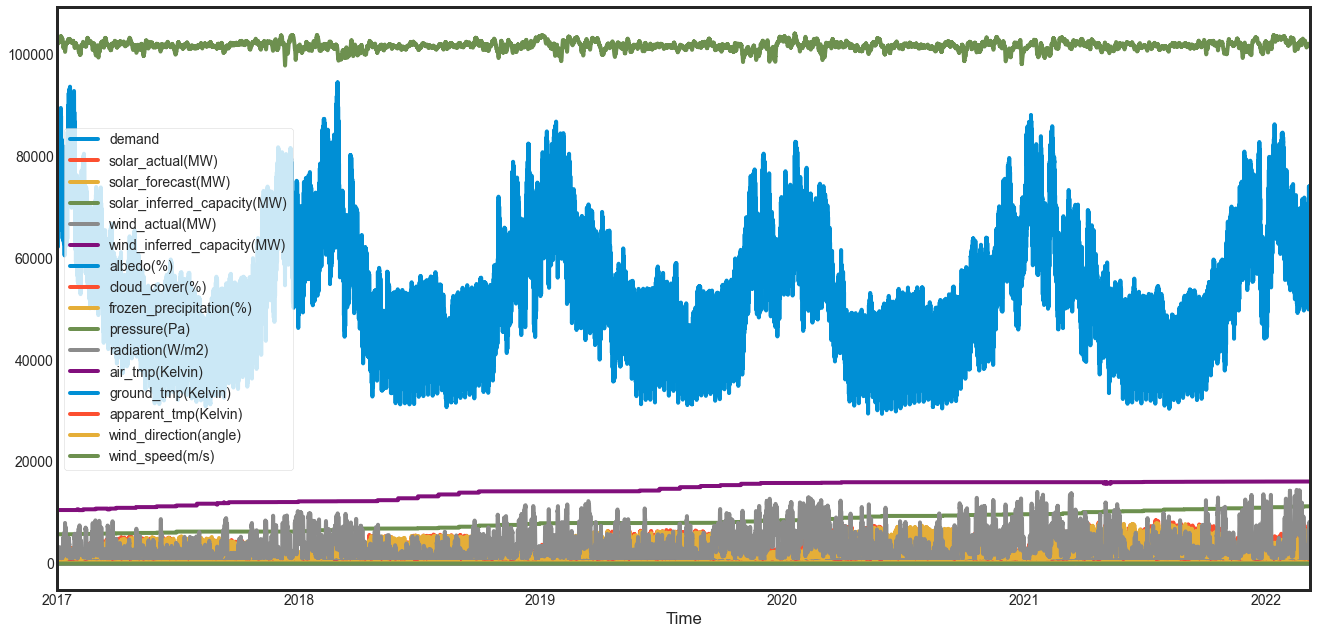

In [29]:
# plot showing date Vs other features in the electricity demand dataset

data.plot(figsize = (20,10))

#### We see a plot of all the features given in the dataset. 
#### The insight drawn from here is how demand varies over the years and how the trend is quite similar over the years. 
#### There is a reduction in electricity in the summer months and the cooler months the electricity demand spikes up again.

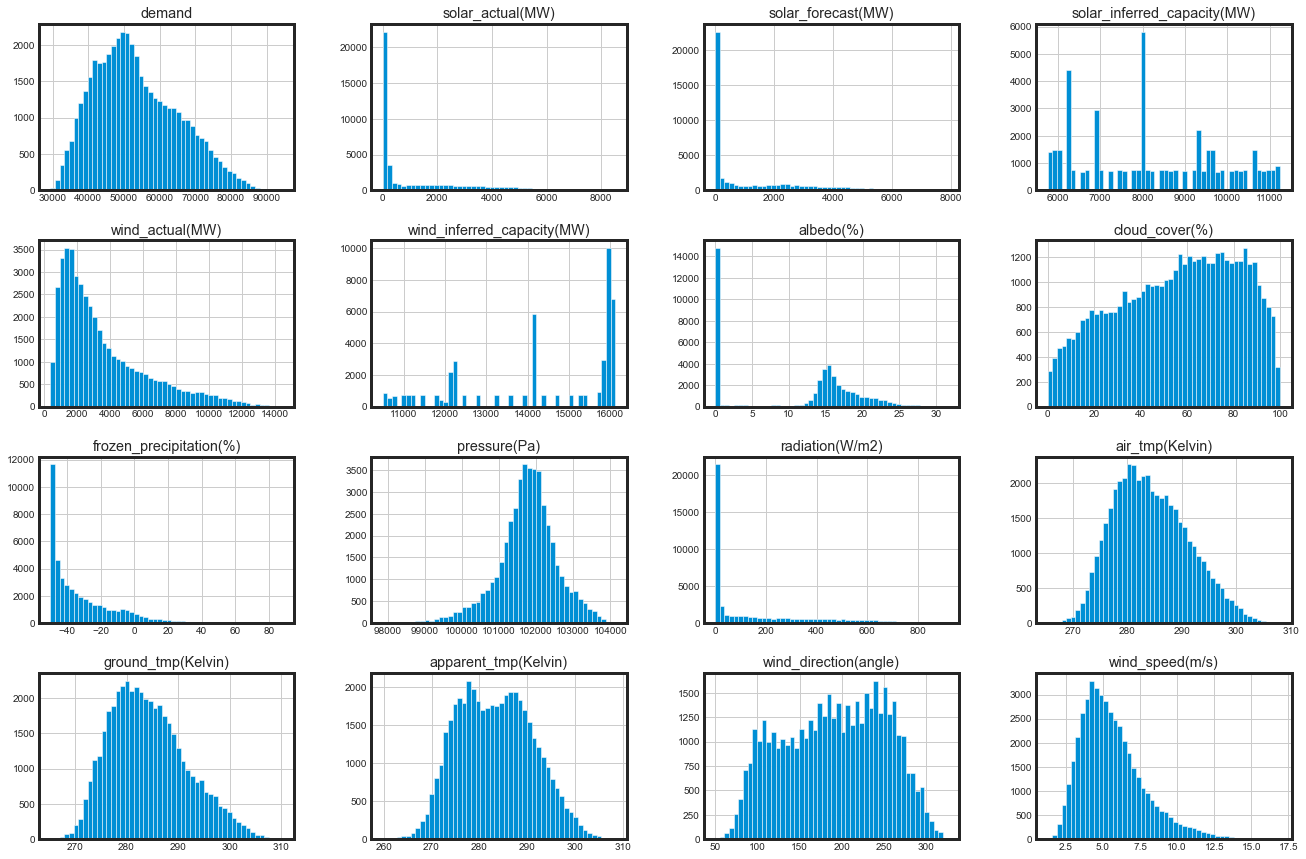

In [30]:
get_ipython().run_line_magic('matplotlib', 'inline')
data.hist(bins=50, figsize=(20,15))
plt.show()

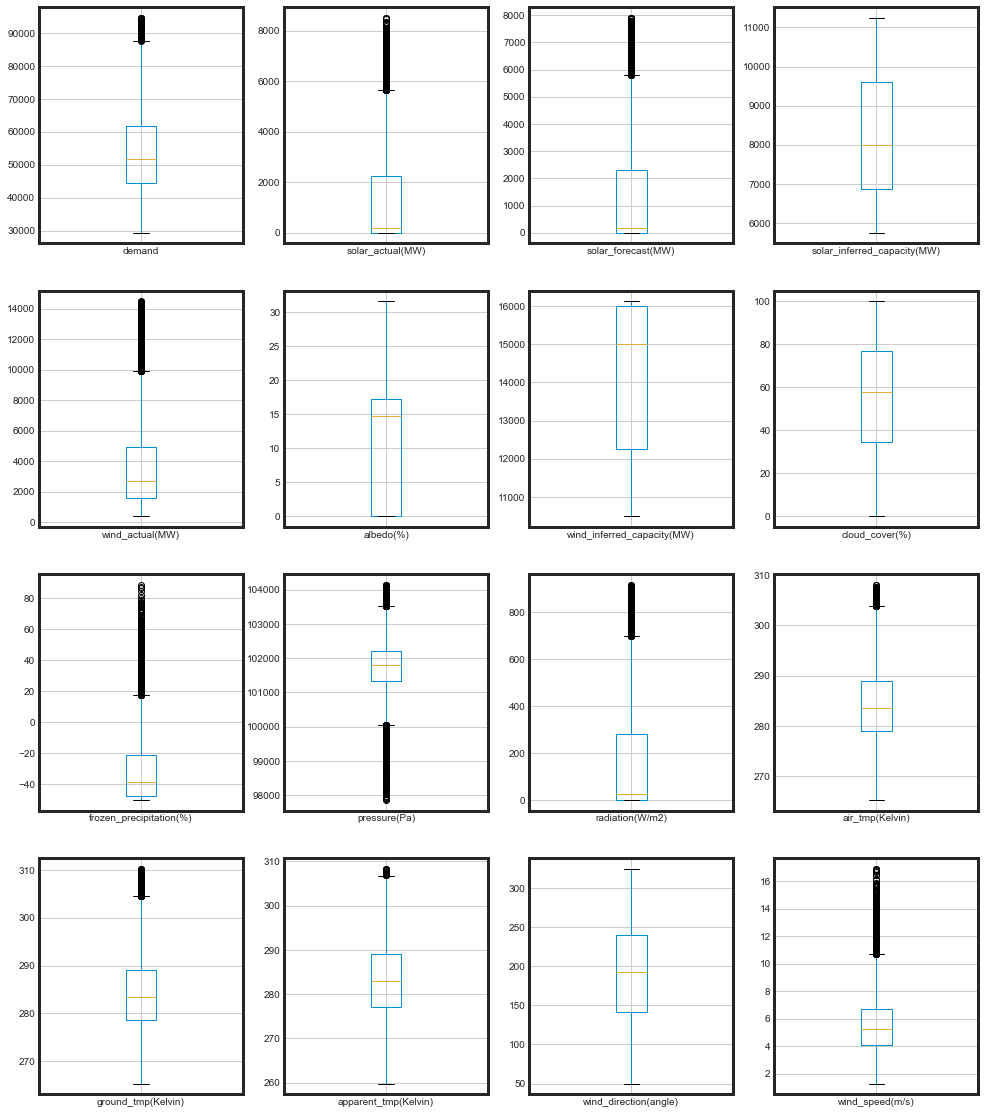

In [31]:
#box plot for all the columns

plt.figure(figsize=(15,20))


plt.subplot(4, 4, 1)
fig = data.boxplot(column='demand')

plt.subplot(4, 4, 2)
fig = data.boxplot(column='solar_actual(MW)')

plt.subplot(4, 4, 3)
fig = data.boxplot(column='solar_forecast(MW)')

plt.subplot(4, 4, 4)
fig = data.boxplot(column='solar_inferred_capacity(MW)')

plt.subplot(4, 4, 5)
fig = data.boxplot(column='wind_actual(MW)')

plt.subplot(4, 4, 6)
fig = data.boxplot(column='albedo(%)')

plt.subplot(4, 4, 7)
fig = data.boxplot(column='wind_inferred_capacity(MW)')

plt.subplot(4, 4, 8)
fig = data.boxplot(column='cloud_cover(%)')

plt.subplot(4, 4, 9)
fig = data.boxplot(column='frozen_precipitation(%)')

plt.subplot(4, 4, 10)
fig = data.boxplot(column='pressure(Pa)')

plt.subplot(4, 4, 11)
fig = data.boxplot(column='radiation(W/m2)')

plt.subplot(4, 4, 12)
fig = data.boxplot(column='air_tmp(Kelvin)')

plt.subplot(4, 4, 13)
fig = data.boxplot(column='ground_tmp(Kelvin)')

plt.subplot(4, 4, 14)
fig = data.boxplot(column='apparent_tmp(Kelvin)')

plt.subplot(4, 4, 15)
fig = data.boxplot(column='wind_direction(angle)')

plt.subplot(4, 4, 16)
fig = data.boxplot(column='wind_speed(m/s)')


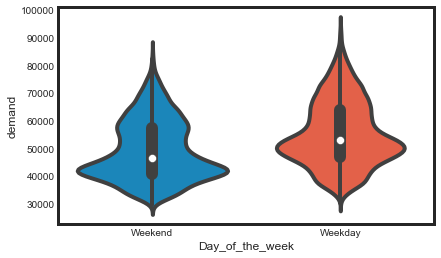

In [32]:
res = sns.violinplot(x="Day_of_the_week", y="demand", data=data)
 
plt.show()

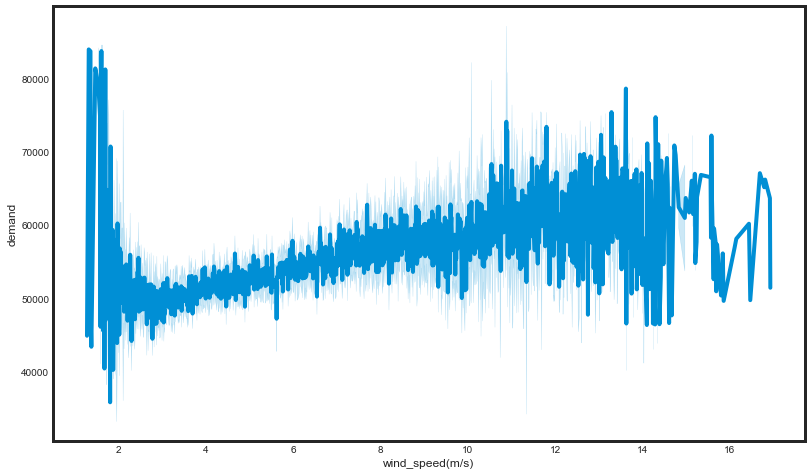

In [33]:
plt.figure(figsize= (12,8))
res = sns.lineplot(x="wind_speed(m/s)", y="demand", data=data)
plt.show()

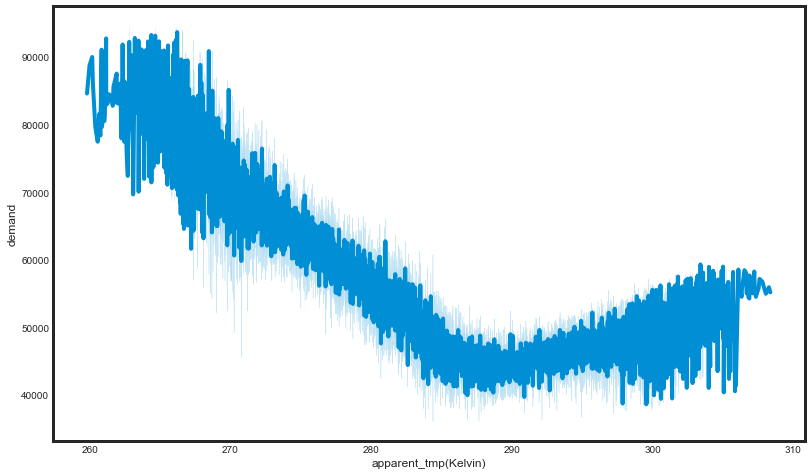

In [34]:
plt.figure(figsize= (12,8))
res = sns.lineplot(x="apparent_tmp(Kelvin)", y="demand", data=data)
plt.show()

#### We can see that the cooler the temperature, the electricity demand is which coincides with our insights on electricity demand being higher in winters.
#### We see a sharp decline in the demand as the temperature rises from 270 Kelvin (-3.25 °Celsius) to 285 Kelvin (6.85 °Celsius).

### Resampling

In [35]:
# saving a copy of main data to perform Resampling
data_resample = data

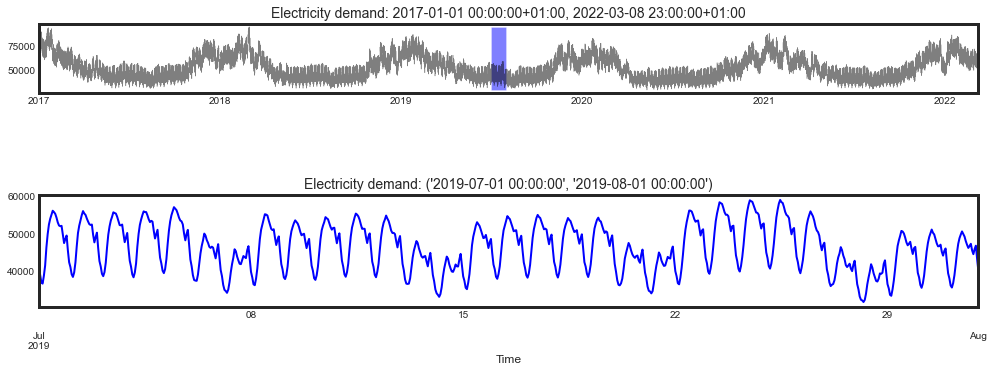

In [36]:
# Zooming in on the demand plot

zoom = ('2019-07-01 00:00:00','2019-08-01 00:00:00')
fig = plt.figure(figsize = (15,6))
grid = plt.GridSpec(nrows = 8, ncols = 1, hspace = 0.6, wspace = 0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:,:])

data_resample.demand.plot(ax=main_ax, c = 'black', alpha = 0.5, linewidth = 0.5)
min_y = min(data_resample.demand)
max_y = max(data_resample.demand)

main_ax.fill_between(zoom, min_y, max_y, facecolor = 'blue', alpha = 0.5, zorder = 0)
main_ax.set_xlabel('')

data_resample.loc[zoom[0]: zoom[1]].demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Electricity demand: {data_resample.index.min()}, {data_resample.index.max()}', fontsize=14)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)


Text(0.5, 0.98, '')

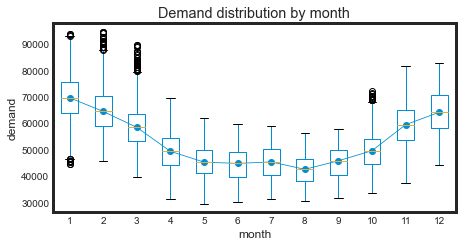

In [37]:
# Boxplot for annual seasonality

fig, ax = plt.subplots(figsize = (7,3.5))
data_resample['month'] = data_resample.index.month
data_resample.boxplot(column = 'demand', by = 'month', ax=ax)
data_resample.groupby('month')['demand'].median().plot(style ='o-', linewidth = 0.8, ax=ax)
ax.set_ylabel('demand')
ax.set_title('Demand distribution by month')
fig.suptitle('')

#### The demand is higher during the winter seasons and during the summer months of June, July, and August the electricity demand is low.
#### This is because solar and wind energy generation increases during the summers with better sunlight and wind patterns in producing clean renewable energy which supplements conventional electricity production. We observe that in August the demand is the least.

Text(0.5, 0.98, '')

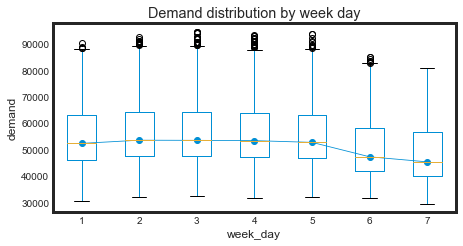

In [38]:
# Boxplot for electricity demand seen in a week

fig, ax = plt.subplots(figsize = (7,3.5))
data_resample['week_day'] = data_resample.index.day_of_week + 1
data_resample.boxplot(column = 'demand', by = 'week_day', ax = ax)
data_resample.groupby('week_day')['demand'].median().plot(style = 'o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('')

#### A representation of the electricity demand over a week. We can see that 6 and 7 which represent ‘Saturday’ and ‘Sunday’ i.e Weekends have less electricity demand compared to the weekdays.

Text(0.5, 0.98, '')

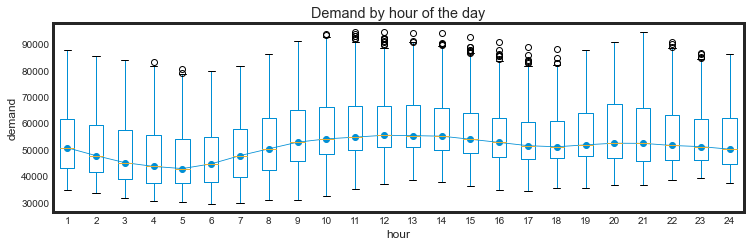

In [39]:
fig, ax = plt.subplots(figsize = (12,3.5))
data_resample['hour'] = data_resample.index.hour + 1
data_resample.boxplot(column = 'demand', by = 'hour', ax=ax)
data_resample.groupby('hour')['demand'].median().plot(style = 'o-', linewidth = 0.8, ax =ax)
ax.set_ylabel('demand')
ax.set_title('Demand by hour of the day')
fig.suptitle('')

#### We see that the early hours of the day such as 4 am – 5 am have the lowest electricity demand compared to the other hours. The demand is generally higher in the waking hours when most people are active and need electricity to carry out their daily activities.

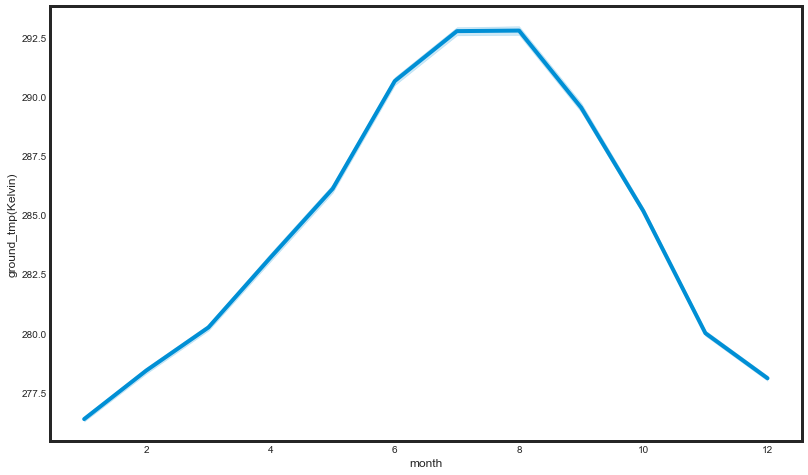

In [40]:
plt.figure(figsize= (12,8))
res = sns.lineplot(x="month", y="ground_tmp(Kelvin)", data=data_resample)
plt.show()

### Analysis based on temperature

In [41]:
extra.head()

,demand,solar_actual(MW),solar_forecast(MW),solar_inferred_capacity(MW),wind_actual(MW),wind_inferred_capacity(MW),albedo(%),cloud_cover(%),frozen_precipitation(%),pressure(Pa),radiation(W/m2),air_tmp(Kelvin),ground_tmp(Kelvin),apparent_tmp(Kelvin),wind_direction(angle),wind_speed(m/s),Day_of_the_week
Time,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+01:00,76345.25,0.0,1278.808883,5756.44,597.50,10513.95,0.0,2.45,-3.80,102875.0,0.0,271.60,269.82,269.84,209.0,2.97,Weekend
2017-01-01 01:00:00+01:00,75437.00,0.0,1278.808883,5756.44,597.50,10513.95,0.0,2.48,-3.46,102839.0,0.0,271.62,269.85,269.79,212.0,3.13,Weekend
2017-01-01 02:00:00+01:00,73368.25,0.0,1278.808883,5756.44,635.25,10513.95,0.0,4.62,-5.48,102735.0,0.0,271.61,269.93,269.58,218.0,3.25,Weekend
2017-01-01 03:00:00+01:00,72116.00,0.0,1278.808883,5756.44,628.50,10513.95,0.0,6.13,-6.91,102660.0,0.0,271.60,269.99,269.44,218.0,3.37,Weekend
2017-01-01 04:00:00+01:00,68593.75,0.0,1278.808883,5756.44,608.50,10513.95,0.0,6.75,-7.50,102629.0,0.0,271.60,270.02,269.38,219.0,3.42,Weekend


In [42]:
extracols = ['solar_actual(MW)', 'solar_forecast(MW)',
       'solar_inferred_capacity(MW)', 'wind_actual(MW)',
       'wind_inferred_capacity(MW)', 'albedo(%)', 'cloud_cover(%)',
       'frozen_precipitation(%)', 'pressure(Pa)', 'radiation(W/m2)',
       'air_tmp(Kelvin)', 'ground_tmp(Kelvin)',
       'wind_direction(angle)', 'wind_speed(m/s)']
extra.drop(extracols, axis = 1 , inplace = True)

In [43]:
extra.head()

,demand,apparent_tmp(Kelvin),Day_of_the_week
Time,,,
2017-01-01 00:00:00+01:00,76345.25,269.84,Weekend
2017-01-01 01:00:00+01:00,75437.00,269.79,Weekend
2017-01-01 02:00:00+01:00,73368.25,269.58,Weekend
2017-01-01 03:00:00+01:00,72116.00,269.44,Weekend
2017-01-01 04:00:00+01:00,68593.75,269.38,Weekend


In [44]:
extra['apparent_tmp(Celsius)'] = extra['apparent_tmp(Kelvin)'] -273.15

In [45]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

In [46]:
# Create a column that has the year of each date recorded
extra['year'] = extra.index.year

In [47]:
# Create a column that has the month of each date recorded
extra["month"] = extra.index.month

In [48]:
# Map the month integers to their proper names

extra["month"] = extra["month"].apply(
    lambda data: months[data-1]
)

In [49]:
# Make this a categorical column so it can be sorted by the proper order of months 

extra["month"] = pd.Categorical(extra["month"], categories=months)

In [50]:
extra['demand'] = extra['demand'].astype(int)

In [51]:
extra.head()

,demand,apparent_tmp(Kelvin),Day_of_the_week,apparent_tmp(Celsius),year,month
Time,,,,,,
2017-01-01 00:00:00+01:00,76345,269.84,Weekend,-3.31,2017,January
2017-01-01 01:00:00+01:00,75437,269.79,Weekend,-3.36,2017,January
2017-01-01 02:00:00+01:00,73368,269.58,Weekend,-3.57,2017,January
2017-01-01 03:00:00+01:00,72116,269.44,Weekend,-3.71,2017,January
2017-01-01 04:00:00+01:00,68593,269.38,Weekend,-3.77,2017,January


##### Assign temperaturature value for analysis

#### Choosing 'apparent_temp(Kelvin)' as from the heat map and correlation analysis, we find apparent temperature has a better correlation to demand(MW) compared to air and ground temperature

In [52]:
a = extra[extra['apparent_tmp(Celsius)'] >= 16]  

In [53]:
extra_pivot = pd.pivot_table(a,values="demand",index="month",columns="Day_of_the_week",aggfunc=np.mean)

Text(0.5, 1.0, 'Weekday Vs Weekend - Month-wise demand according to temperature')

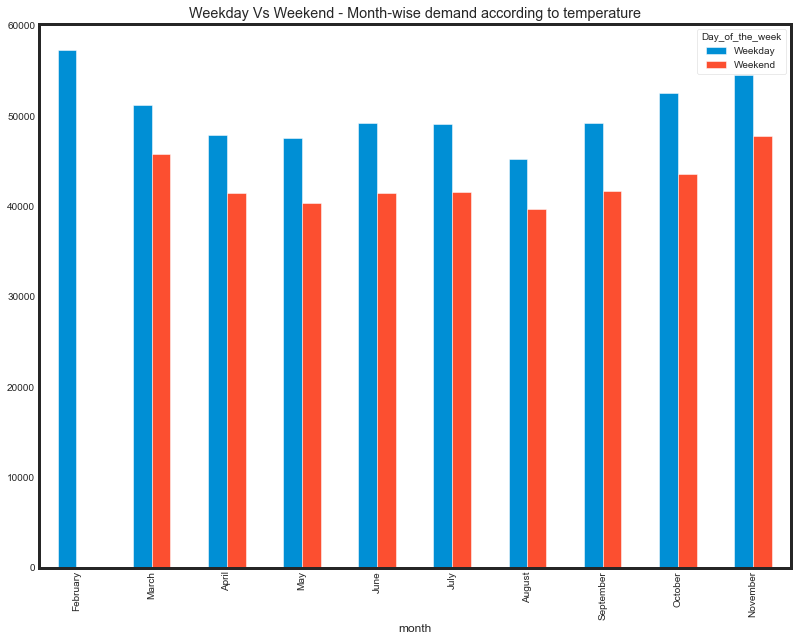

In [54]:
# Plot a bar chart using the DF
ax = extra_pivot.plot(kind="bar") 
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(12, 10)
plt.title("Weekday Vs Weekend - Month-wise demand according to temperature")

#### The graph is plotted with an apparent temperature >= 15 °C.(We can change the temperature as needed)  It is interesting to note that in February, the demand on weekends is not visible because the temperatures are seemingly lower on the weekends in February. We can see that January and December are not even in the picture due to cooler temperatures.

<AxesSubplot:>

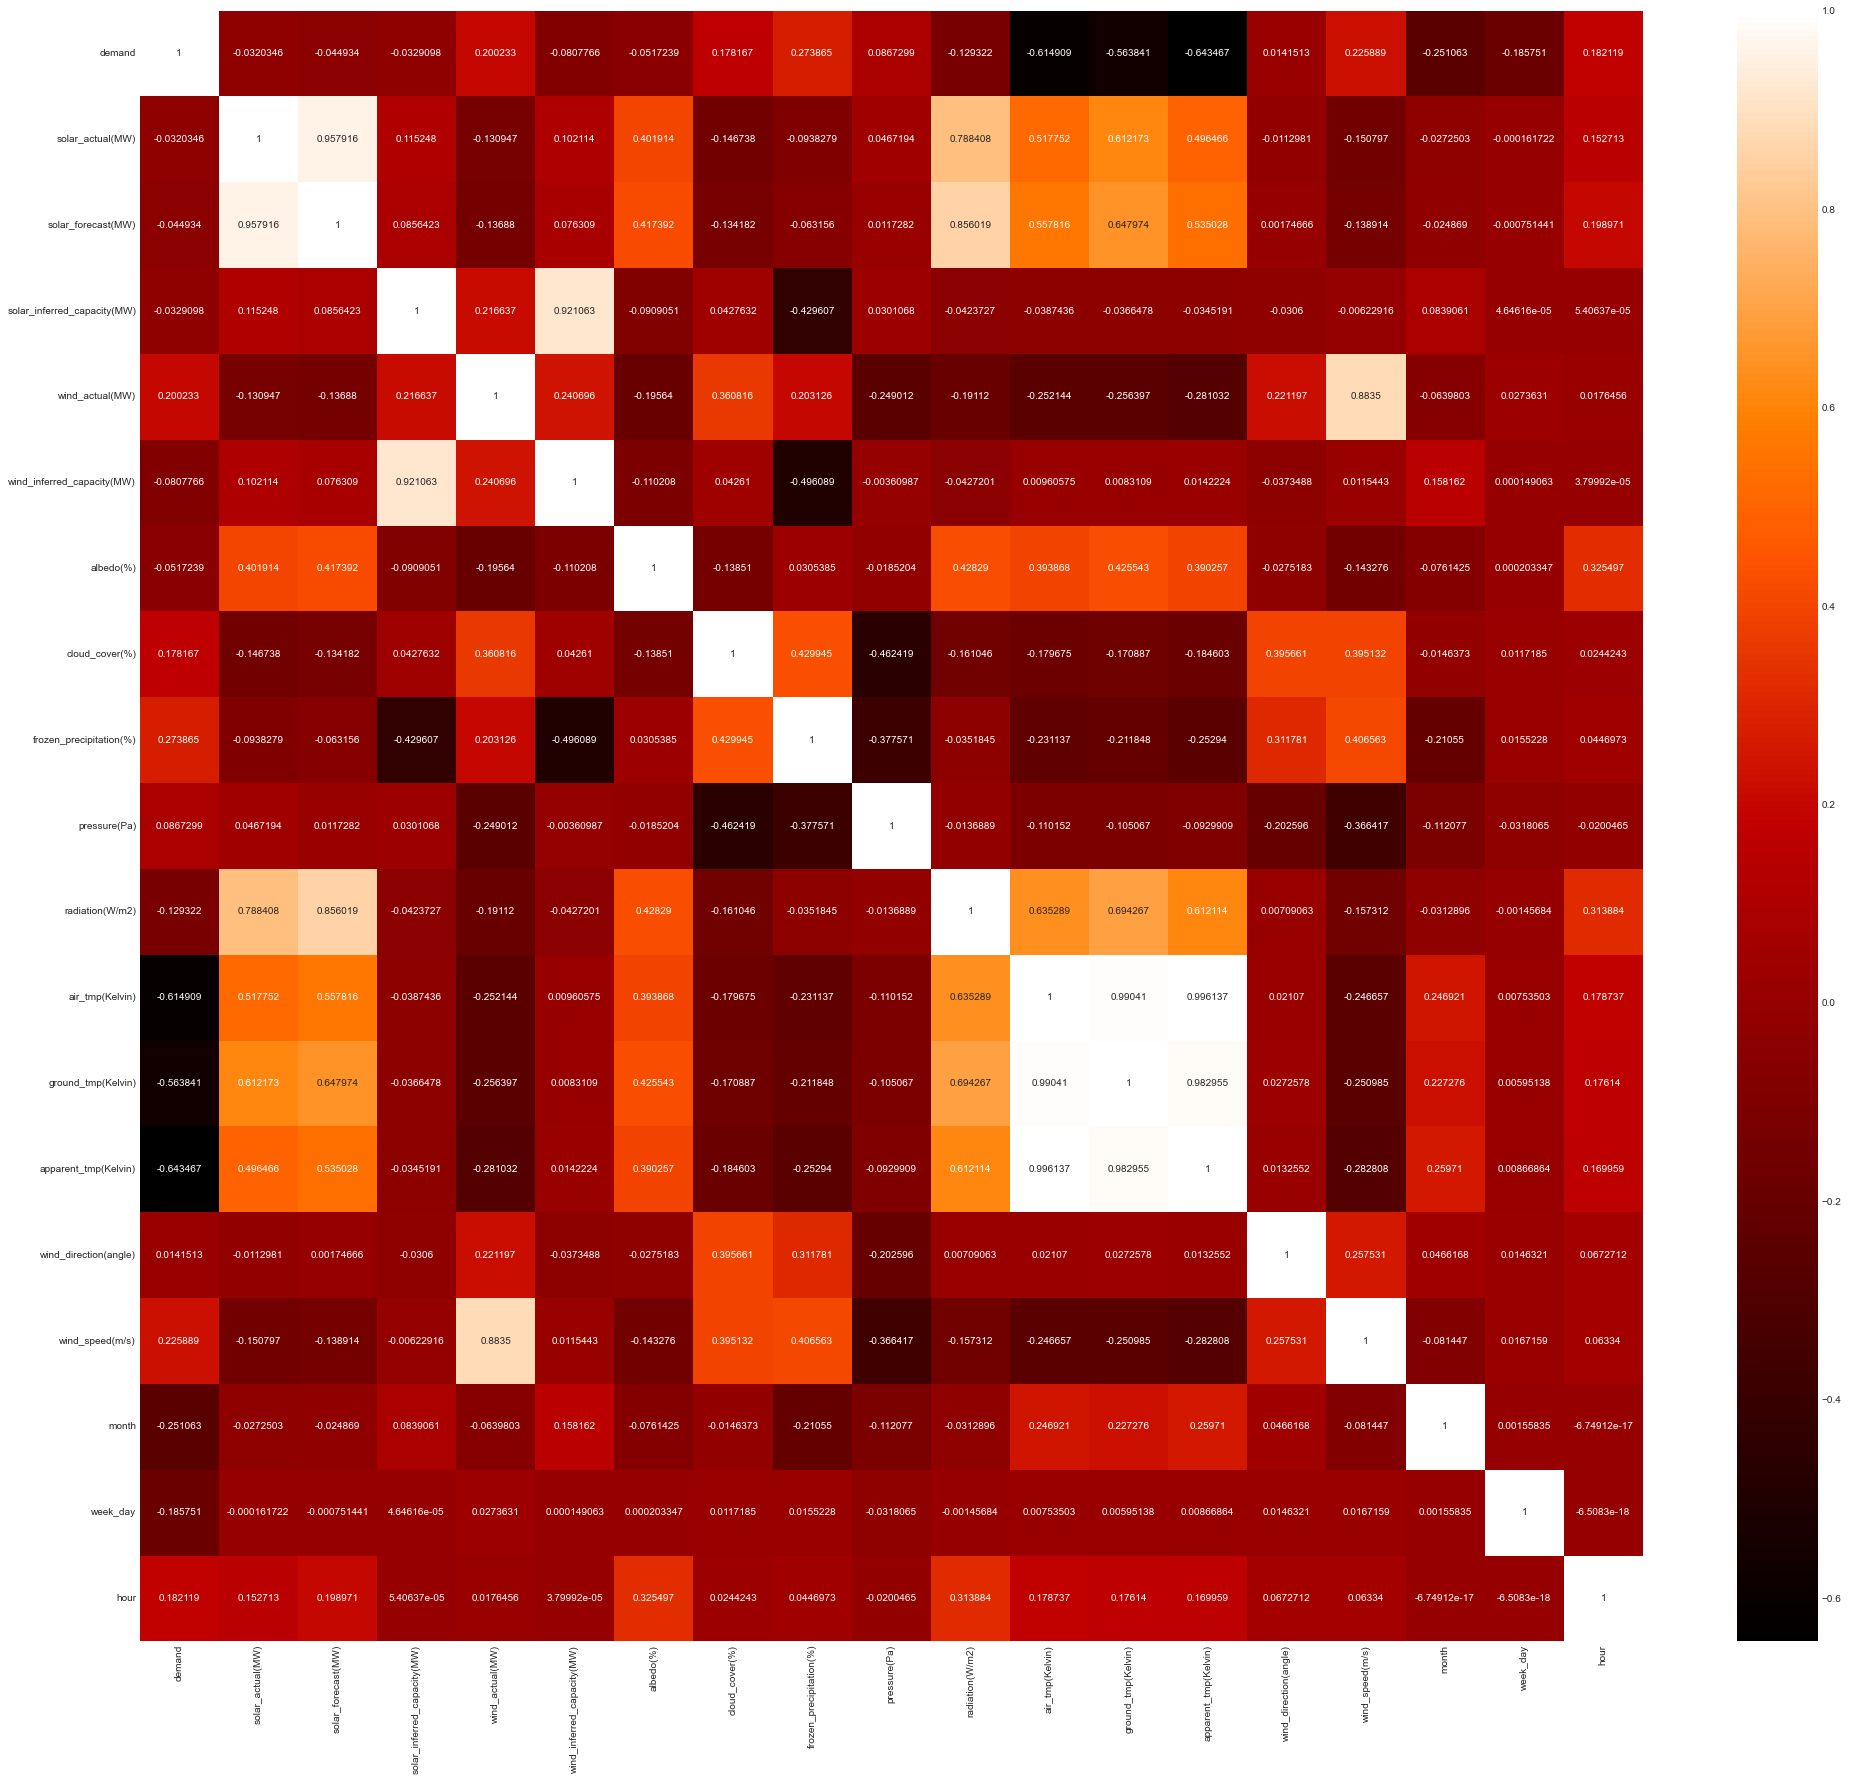

In [55]:
plt.figure(figsize = (30,30))
sns.heatmap(data.corr(),annot= True, fmt="1g", cmap='gist_heat', cbar=True)

In [56]:
#Checking which columns are mostly correlated with the target
data.corr().abs()['demand'].sort_values(ascending = False)

demand                         1.000000
apparent_tmp(Kelvin)           0.643467
air_tmp(Kelvin)                0.614909
ground_tmp(Kelvin)             0.563841
frozen_precipitation(%)        0.273865
month                          0.251063
wind_speed(m/s)                0.225889
wind_actual(MW)                0.200233
week_day                       0.185751
hour                           0.182119
cloud_cover(%)                 0.178167
radiation(W/m2)                0.129322
pressure(Pa)                   0.086730
wind_inferred_capacity(MW)     0.080777
albedo(%)                      0.051724
solar_forecast(MW)             0.044934
solar_inferred_capacity(MW)    0.032910
solar_actual(MW)               0.032035
wind_direction(angle)          0.014151
Name: demand, dtype: float64

## Encoding the data

In [57]:
from sklearn.preprocessing import LabelEncoder


# Instantiate LabelEncoder

le = LabelEncoder()

# Encode single column status

data.Day_of_the_week = le.fit_transform(data.Day_of_the_week)

data.head()

,demand,solar_actual(MW),solar_forecast(MW),solar_inferred_capacity(MW),wind_actual(MW),wind_inferred_capacity(MW),albedo(%),cloud_cover(%),frozen_precipitation(%),pressure(Pa),radiation(W/m2),air_tmp(Kelvin),ground_tmp(Kelvin),apparent_tmp(Kelvin),wind_direction(angle),wind_speed(m/s),Day_of_the_week,month,week_day,hour
Time,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+01:00,76345.25,0.0,1278.808883,5756.44,597.50,10513.95,0.0,2.45,-3.80,102875.0,0.0,271.60,269.82,269.84,209.0,2.97,1,1,7,1
2017-01-01 01:00:00+01:00,75437.00,0.0,1278.808883,5756.44,597.50,10513.95,0.0,2.48,-3.46,102839.0,0.0,271.62,269.85,269.79,212.0,3.13,1,1,7,2
2017-01-01 02:00:00+01:00,73368.25,0.0,1278.808883,5756.44,635.25,10513.95,0.0,4.62,-5.48,102735.0,0.0,271.61,269.93,269.58,218.0,3.25,1,1,7,3
2017-01-01 03:00:00+01:00,72116.00,0.0,1278.808883,5756.44,628.50,10513.95,0.0,6.13,-6.91,102660.0,0.0,271.60,269.99,269.44,218.0,3.37,1,1,7,4
2017-01-01 04:00:00+01:00,68593.75,0.0,1278.808883,5756.44,608.50,10513.95,0.0,6.75,-7.50,102629.0,0.0,271.60,270.02,269.38,219.0,3.42,1,1,7,5


In [58]:
# saving a copy of Main data to perform timeseries analysis
data_ts = data.copy()

#### Creating a copy called encoded data as it makes the model more standardized and helps in regression algorithms and standardizes the data to regression metrics accurately

In [59]:
encoded_data = data.copy()  

In [60]:
# Standardizing the dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoded_data = pd.DataFrame(scaler.fit_transform(encoded_data), columns=encoded_data.columns)
encoded_data.head()

,demand,solar_actual(MW),solar_forecast(MW),solar_inferred_capacity(MW),wind_actual(MW),wind_inferred_capacity(MW),albedo(%),cloud_cover(%),frozen_precipitation(%),pressure(Pa),radiation(W/m2),air_tmp(Kelvin),ground_tmp(Kelvin),apparent_tmp(Kelvin),wind_direction(angle),wind_speed(m/s),Day_of_the_week,month,week_day,hour
0,1.932788,-0.72171,2.976404e-15,-1.545667,-1.114262,-2.056999,-1.316578,-2.041396,1.381642,1.407204,-0.729615,-1.857823,-1.930279,-1.708563,0.312861,-1.226846,1.580847,-1.526044,1.499539,-1.661325
1,1.855876,-0.72171,2.976404e-15,-1.545667,-1.114262,-2.056999,-1.316578,-2.040237,1.398603,1.361978,-0.729615,-1.854903,-1.926264,-1.714927,0.362928,-1.152641,1.580847,-1.526044,1.499539,-1.516862
2,1.680691,-0.72171,2.976404e-15,-1.545667,-1.100321,-2.056999,-1.316578,-1.957530,1.297839,1.231326,-0.729615,-1.856363,-1.915558,-1.741658,0.463061,-1.096988,1.580847,-1.526044,1.499539,-1.372399
3,1.574649,-0.72171,2.976404e-15,-1.545667,-1.102814,-2.056999,-1.316578,-1.899172,1.226506,1.137106,-0.729615,-1.857823,-1.907529,-1.759479,0.463061,-1.041334,1.580847,-1.526044,1.499539,-1.227936
4,1.276380,-0.72171,2.976404e-15,-1.545667,-1.110200,-2.056999,-1.316578,-1.875211,1.197075,1.098161,-0.729615,-1.857823,-1.903514,-1.767116,0.479750,-1.018145,1.580847,-1.526044,1.499539,-1.083473


# Regressive Algorithms

In [61]:
y = pd.DataFrame(encoded_data['demand'])  # Target Variable
x = pd.DataFrame(encoded_data.drop(['demand'], axis=1))  # Dependent Variables


In [62]:
x.head()

,solar_actual(MW),solar_forecast(MW),solar_inferred_capacity(MW),wind_actual(MW),wind_inferred_capacity(MW),albedo(%),cloud_cover(%),frozen_precipitation(%),pressure(Pa),radiation(W/m2),air_tmp(Kelvin),ground_tmp(Kelvin),apparent_tmp(Kelvin),wind_direction(angle),wind_speed(m/s),Day_of_the_week,month,week_day,hour
0,-0.72171,2.976404e-15,-1.545667,-1.114262,-2.056999,-1.316578,-2.041396,1.381642,1.407204,-0.729615,-1.857823,-1.930279,-1.708563,0.312861,-1.226846,1.580847,-1.526044,1.499539,-1.661325
1,-0.72171,2.976404e-15,-1.545667,-1.114262,-2.056999,-1.316578,-2.040237,1.398603,1.361978,-0.729615,-1.854903,-1.926264,-1.714927,0.362928,-1.152641,1.580847,-1.526044,1.499539,-1.516862
2,-0.72171,2.976404e-15,-1.545667,-1.100321,-2.056999,-1.316578,-1.957530,1.297839,1.231326,-0.729615,-1.856363,-1.915558,-1.741658,0.463061,-1.096988,1.580847,-1.526044,1.499539,-1.372399
3,-0.72171,2.976404e-15,-1.545667,-1.102814,-2.056999,-1.316578,-1.899172,1.226506,1.137106,-0.729615,-1.857823,-1.907529,-1.759479,0.463061,-1.041334,1.580847,-1.526044,1.499539,-1.227936
4,-0.72171,2.976404e-15,-1.545667,-1.110200,-2.056999,-1.316578,-1.875211,1.197075,1.098161,-0.729615,-1.857823,-1.903514,-1.767116,0.479750,-1.018145,1.580847,-1.526044,1.499539,-1.083473


In [63]:
y.head()

,demand
0,1.932788
1,1.855876
2,1.680691
3,1.574649
4,1.276380


In [64]:
from sklearn.model_selection import train_test_split

# implementing train-test-split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt


In [65]:
print('x_train shape is: ', x_train.shape)
print('y_train shape is: ', y_train.shape)
print('x_test shape is: ', x_test.shape)
print('y_test shape is: ', y_test.shape)

x_train shape is:  (36345, 19)
y_train shape is:  (36345, 1)
x_test shape is:  (9087, 19)
y_test shape is:  (9087, 1)


## Adaboost Regressor

In [66]:
#Adaboost Regressor 

from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(random_state=0)
ada.fit(x_train, y_train)
#predict our test set
y_pred = ada.predict(x_test)

In [67]:
print(y_pred)

[-0.47684229 -0.23478613 -0.17367993 ... -0.04986084 -0.35339459
  0.21119921]


In [68]:
A_train = ada.score(x_train, y_train)
print(A_train)

0.8269737379324346


In [69]:
A_test = ada.score(x_test, y_test)
print(A_test)

0.8289826007654895


In [70]:

A_MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(round(A_MAE, 2)))

A_MSE = mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(round(A_MSE, 2)))

A_RMSE = sqrt(A_MSE)
print('Root Mean Square Error  : %f' % A_RMSE)

A_R2_SCORE=r2_score(y_test, y_pred)
print('R2_SCORE (Coefficient Of Determination)  : %f' % A_R2_SCORE)

A_Accuracy = print("Accuracy: " , round(A_test*100, 2) , "%")

Mean Absolute Error : 0.34
Mean Squared Error : 0.17
Root Mean Square Error  : 0.416024
R2_SCORE (Coefficient Of Determination)  : 0.828983
Accuracy:  82.9 %


## Decision Tree Regressor

In [71]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)

DecisionTreeRegressor()

In [72]:
y_pred = dt.predict(x_test)

In [73]:
B_train = dt.score(x_train, y_train)
print(B_train)

1.0


In [74]:
B_test = dt.score(x_test, y_test)
print(B_test)

0.9289996464521693


In [75]:
B_MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(round(B_MAE, 2)))

B_MSE = mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(round(B_MSE, 2)))

B_RMSE = sqrt(B_MSE)
print('Root Mean Square Error  : %f' % B_RMSE)

B_R2_SCORE=r2_score(y_test, y_pred)
print('R2_SCORE (Coefficient Of Determination)  : %f' % B_R2_SCORE)

B_Accuracy = print("Accuracy: " , round(B_test*100, 2) , "%")

Mean Absolute Error : 0.18
Mean Squared Error : 0.07
Root Mean Square Error  : 0.268058
R2_SCORE (Coefficient Of Determination)  : 0.929000
Accuracy:  92.9 %


## Linear Regression

In [76]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train, y_train)

LinearRegression()

In [77]:
y_pred = LR.predict(x_test)

In [78]:
C_train = LR.score(x_train, y_train)
print(C_train)

0.7152202997992065


In [79]:
C_test = LR.score(x_test, y_test)
print(C_test)

0.7220478476508949


In [80]:
LR.coef_

array([[ 0.07200201,  0.24597303, -0.05251734,  0.07614345, -0.06037098,
         0.07880726,  0.14179633, -0.01087722,  0.07080868, -0.04340734,
         2.60766308,  0.04997205, -3.50135885, -0.02723248, -0.15032106,
        -0.24634761,  0.03158379,  0.02149533,  0.23860501]])

In [81]:
LR.intercept_

array([-0.00053612])

In [82]:
C_MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(round(C_MAE, 2)))

C_MSE = mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(round(C_MSE, 2)))

C_RMSE = sqrt(C_MSE)
print('Root Mean Square Error  : %f' % C_RMSE)

C_R2_SCORE=r2_score(y_test, y_pred)
print('R2_SCORE (Coefficient Of Determination)  : %f' % C_R2_SCORE)

C_Accuracy = print("Accuracy: " , round(C_test*100, 2) , "%")

Mean Absolute Error : 0.42
Mean Squared Error : 0.28
Root Mean Square Error  : 0.530375
R2_SCORE (Coefficient Of Determination)  : 0.722048
Accuracy:  72.2 %


## Random Forest Regressor

In [83]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(max_samples=0.8)
rfc.fit(x_train,y_train)

RandomForestRegressor(max_samples=0.8)

In [84]:
y_pred = rfc.predict(x_test)

In [85]:
D_train = rfc.score(x_train, y_train)
print(D_train)

0.9928853584705111


In [86]:
D_test = rfc.score(x_test, y_test)
print(D_test)

0.9662260866142655


In [87]:
D_MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(round(D_MAE, 2)))

D_MSE = mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(round(D_MSE, 2)))

D_RMSE = sqrt(D_MSE)
print('Root Mean Square Error  : %f' % D_RMSE)

D_R2_SCORE=r2_score(y_test, y_pred)
print('R2_SCORE (Coefficient Of Determination)  : %f' % D_R2_SCORE)

D_Accuracy = print("Accuracy: " , round(D_test*100, 2) , "%")

Mean Absolute Error : 0.13
Mean Squared Error : 0.03
Root Mean Square Error  : 0.184880
R2_SCORE (Coefficient Of Determination)  : 0.966226
Accuracy:  96.62 %


## XGBoost Regressor

In [88]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

xg = XGBRegressor()
xg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [89]:
y_pred = xg.predict(x_test)

In [90]:
E_train = xg.score(x_train, y_train)
print(E_train)

0.9841408706933464


In [91]:
E_test = xg.score(x_test, y_test)
print(E_test)

0.9752951803238397


In [92]:
E_MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(round(E_MAE, 2)))

E_MSE = mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(round(E_MSE, 2)))

E_RMSE = sqrt(E_MSE)
print('Root Mean Square Error  : %f' % E_RMSE)

E_R2_SCORE=r2_score(y_test, y_pred)
print('R2_SCORE (Coefficient Of Determination)  : %f' % E_R2_SCORE)

E_Accuracy = print("Accuracy: " , round(E_test*100, 2) , "%")

Mean Absolute Error : 0.11
Mean Squared Error : 0.03
Root Mean Square Error  : 0.158121
R2_SCORE (Coefficient Of Determination)  : 0.975295
Accuracy:  97.53 %


## KNN Regressor

In [93]:
from sklearn.neighbors import KNeighborsRegressor

# checking the accuracy while looping throught the neighbors count from 1 to 5

for n in range(1,6):
    knn = KNeighborsRegressor(n_neighbors = n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    print('KNeighborsRegressor: n = {} , Accuracy is: {}'.format(n,knn.score(x_test,y_test)))

KNeighborsRegressor: n = 1 , Accuracy is: 0.950317932844894
KNeighborsRegressor: n = 2 , Accuracy is: 0.9505845904312751
KNeighborsRegressor: n = 3 , Accuracy is: 0.9407302191379581
KNeighborsRegressor: n = 4 , Accuracy is: 0.9336389819221597
KNeighborsRegressor: n = 5 , Accuracy is: 0.9279537729701467


In [94]:
knn = KNeighborsRegressor(n_neighbors = 2)   #Since n= 2 gives the highest accuracy
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
F_test = knn.score(x_test,y_test)

In [95]:
F_MAE = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error : {}'.format(round(F_MAE, 2)))

F_MSE = mean_squared_error(y_test, y_pred)
print('Mean Squared Error : {}'.format(round(F_MSE, 2)))

F_RMSE = sqrt(F_MSE)
print('Root Mean Square Error  : %f' % F_RMSE)

F_R2_SCORE=r2_score(y_test, y_pred)
print('R2_SCORE (Coefficient Of Determination)  : %f' % F_R2_SCORE)

F_Accuracy = print("Accuracy: " , round(F_test*100, 2) , "%")

Mean Absolute Error : 0.15
Mean Squared Error : 0.05
Root Mean Square Error  : 0.223630
R2_SCORE (Coefficient Of Determination)  : 0.950585
Accuracy:  95.06 %


## Plotting a bar graph for accuracy of the algorithms used

In [96]:
algorithms = ['AdaBoost Regressor', 'Decision Tree Regressor', 'Linear Regression', 'Random Forest Regressor', 'XGboost Regressor', 'KNN']
accuracy = [A_test *100, B_test*100, C_test*100, D_test*100, E_test*100, F_test*100]
total_mae = [A_MAE,B_MAE,C_MAE,D_MAE,E_MAE,F_MAE]
total_mse = [A_MSE,B_MSE,C_MSE,D_MSE,E_MSE,F_MSE]
total_rmse = [A_RMSE,B_RMSE,C_RMSE,D_RMSE,E_RMSE,F_RMSE]
R2_score_total = [A_R2_SCORE,B_R2_SCORE,C_R2_SCORE,D_R2_SCORE,E_R2_SCORE,F_R2_SCORE]

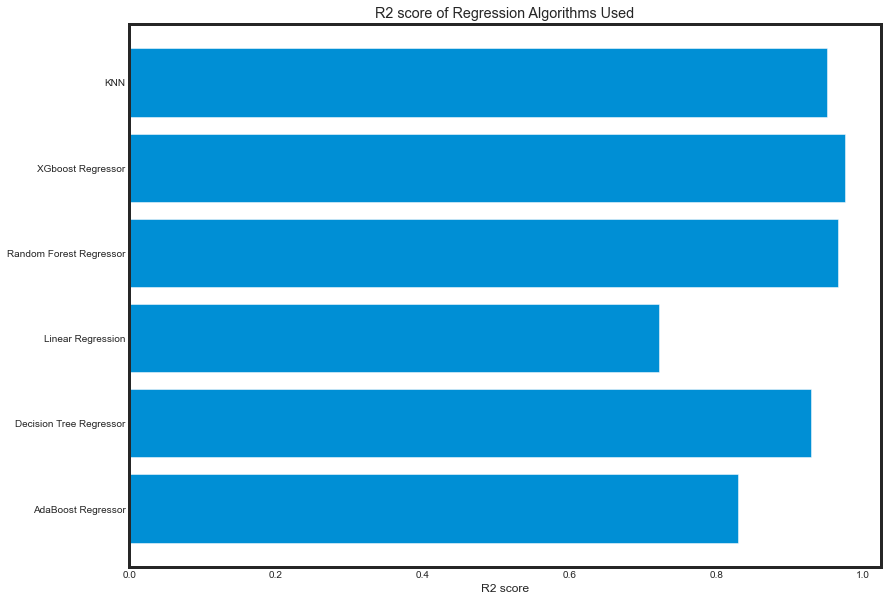

In [97]:
plt.figure(figsize = (12,10))
plt.barh(algorithms,R2_score_total)
plt.title('R2 score of Regression Algorithms Used')
plt.xlabel('R2 score')
plt.show()

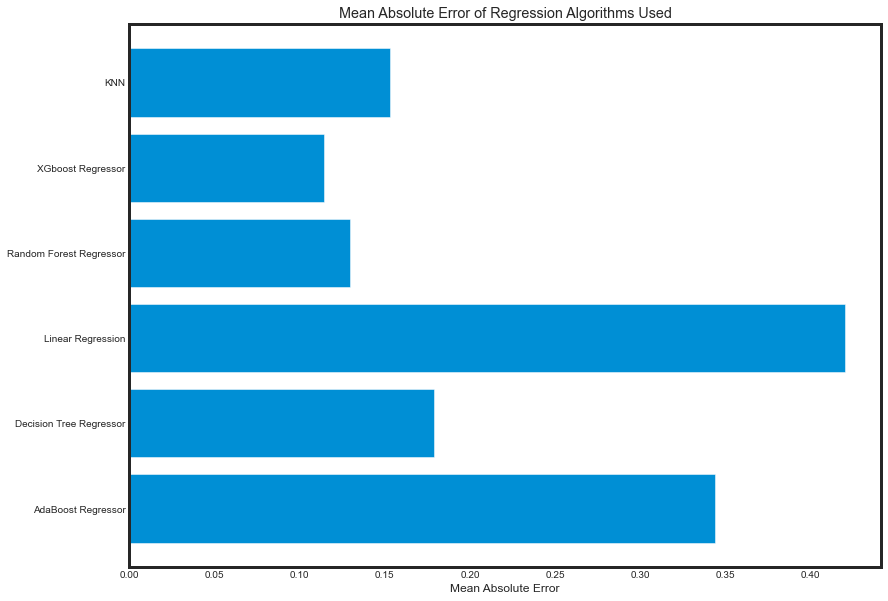

In [98]:
plt.figure(figsize = (12,10))
plt.barh(algorithms,total_mae)
plt.title('Mean Absolute Error of Regression Algorithms Used')
plt.xlabel('Mean Absolute Error')
plt.show()

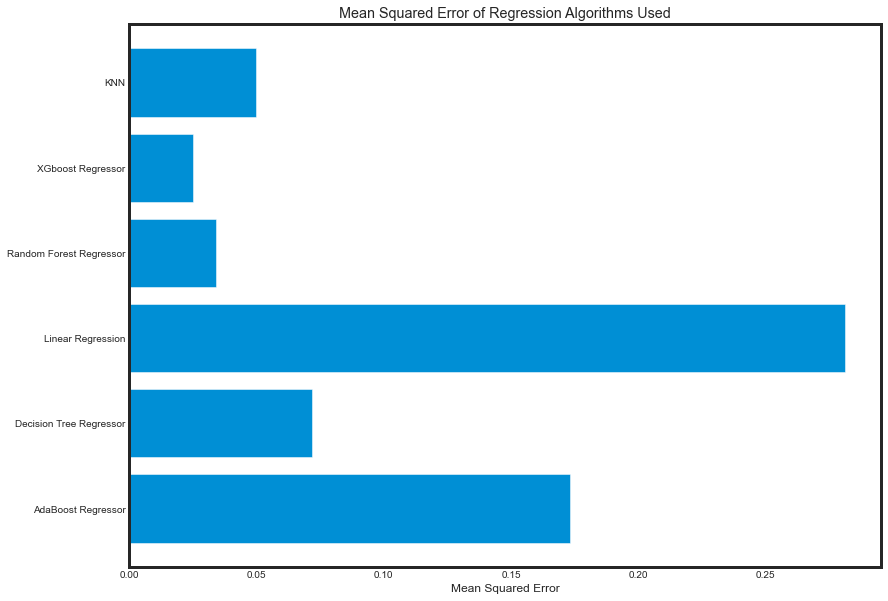

In [99]:
plt.figure(figsize = (12,10))
plt.barh(algorithms,total_mse)
plt.title('Mean Squared Error of Regression Algorithms Used')
plt.xlabel('Mean Squared Error')
plt.show()

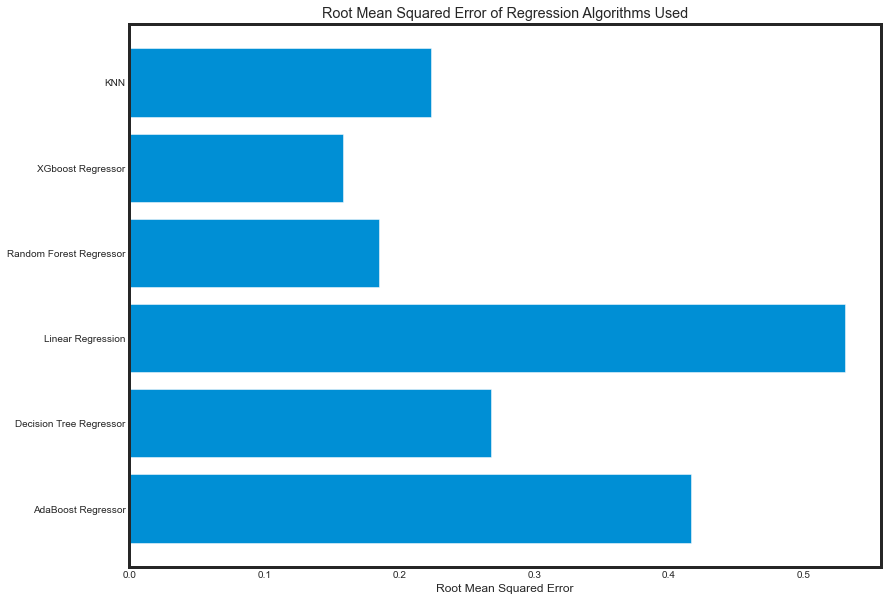

In [100]:
plt.figure(figsize = (12,10))
plt.barh(algorithms,total_rmse)
plt.title('Root Mean Squared Error of Regression Algorithms Used')
plt.xlabel('Root Mean Squared Error')
plt.show()

# Time Series Analysis

In [101]:
import statsmodels.api as sm

In [102]:
data_ts.columns

Index(['demand', 'solar_actual(MW)', 'solar_forecast(MW)',
       'solar_inferred_capacity(MW)', 'wind_actual(MW)',
       'wind_inferred_capacity(MW)', 'albedo(%)', 'cloud_cover(%)',
       'frozen_precipitation(%)', 'pressure(Pa)', 'radiation(W/m2)',
       'air_tmp(Kelvin)', 'ground_tmp(Kelvin)', 'apparent_tmp(Kelvin)',
       'wind_direction(angle)', 'wind_speed(m/s)', 'Day_of_the_week', 'month',
       'week_day', 'hour'],
      dtype='object')

In [103]:
cols = ['solar_actual(MW)', 'solar_forecast(MW)',
       'solar_inferred_capacity(MW)', 'wind_actual(MW)',
       'wind_inferred_capacity(MW)', 'albedo(%)', 'cloud_cover(%)',
       'frozen_precipitation(%)', 'pressure(Pa)', 'radiation(W/m2)',
       'air_tmp(Kelvin)', 'ground_tmp(Kelvin)', 'apparent_tmp(Kelvin)',
       'wind_direction(angle)', 'wind_speed(m/s)','Day_of_the_week','month','week_day','hour']
data_ts.drop(cols, axis = 1 , inplace = True)

In [104]:
data_ts.head()

,demand
Time,
2017-01-01 00:00:00+01:00,76345.25
2017-01-01 01:00:00+01:00,75437.00
2017-01-01 02:00:00+01:00,73368.25
2017-01-01 03:00:00+01:00,72116.00
2017-01-01 04:00:00+01:00,68593.75


In [105]:
data_ts['demand'] = data_ts['demand'].astype(int)

In [106]:
data_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45432 entries, 2017-01-01 00:00:00+01:00 to 2022-03-08 23:00:00+01:00
Freq: 60T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   demand  45432 non-null  int32
dtypes: int32(1)
memory usage: 1.5 MB


In [107]:
# Making another copy of the data called timeSeries for later purpose if needed

timeSeries = data_ts

In [108]:
timeSeries.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45432 entries, 2017-01-01 00:00:00+01:00 to 2022-03-08 23:00:00+01:00
Freq: 60T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   demand  45432 non-null  int32
dtypes: int32(1)
memory usage: 1.5 MB


<AxesSubplot:xlabel='Time'>

<Figure size 1152x576 with 0 Axes>

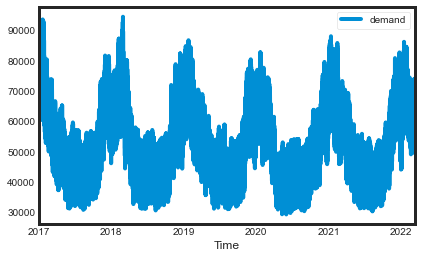

In [109]:
plt.figure(figsize = (16,8))
data_ts.plot()

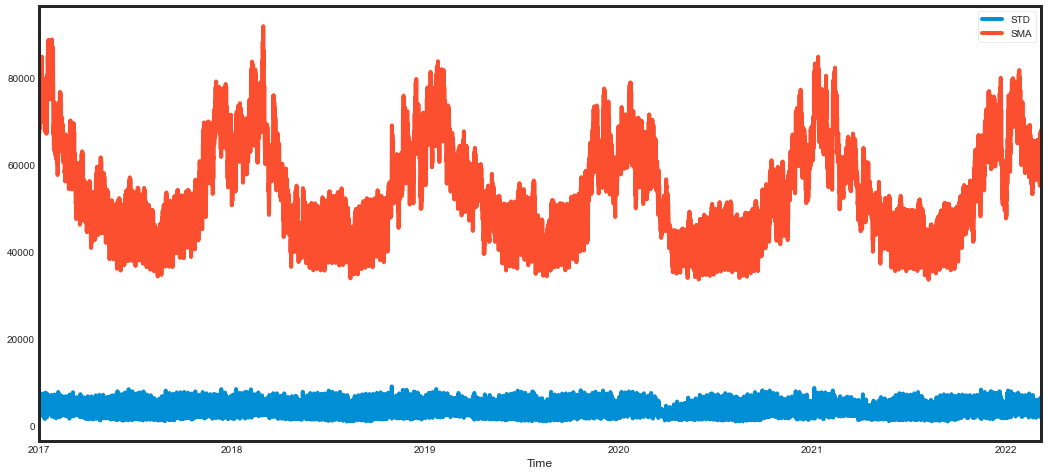

In [110]:
# Plotting the Simple Moving Average (SMA) to understand the trend and also the Standard Deviation (STD) curve 

data_ts['demand'].rolling(12).std().plot(label='STD')
data_ts['demand'].rolling(12).mean().plot(label='SMA',figsize=(16,8))

plt.legend()

####  From the graph above we see that the Standard Deviation does not change much

## Decomposition of the time series data to its trend, seasonality and residual components.

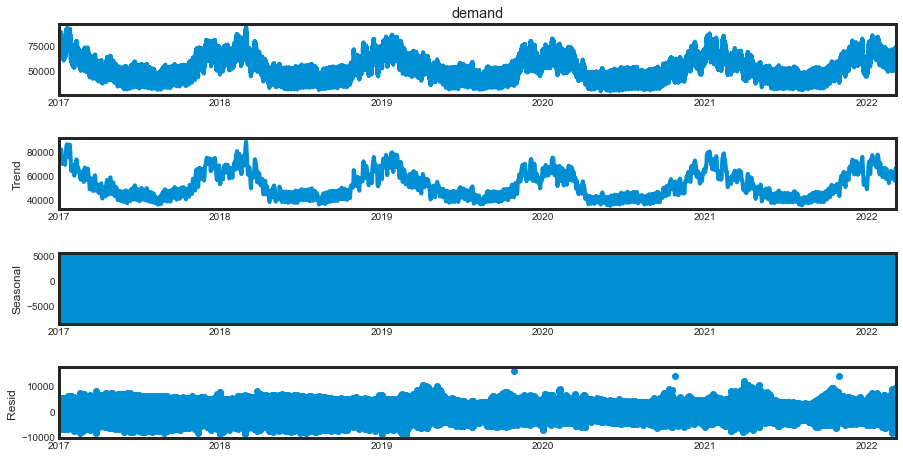

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(data_ts['demand'])
fig = decomp.plot()
fig.set_size_inches(14,7)

#### We can see that the data is stationary as per the seasonality shown above. But we will do a stationarity test to confirm the same.

## Augmented Dickey-Fuller (ADF) Test for Stationarity

In [112]:
from statsmodels.tsa.stattools import adfuller

fuller_test = adfuller(data_ts['demand'])
fuller_test

(-7.374123712923973,
 8.813621317254258e-11,
 55,
 45376,
 {'1%': -3.430494121781775,
  '5%': -2.8616036987246276,
  '10%': -2.566803904749316},
 718365.5112371877)

In [113]:
def test_p_value(adf_data):
    fuller_test = adfuller(adf_data)
    print('p-value: ', fuller_test[1])
    if fuller_test[1] <= 0.05: 
        print('Reject the null hypothesis, data is stationary')
    else:
        print('Do not reject the null hypothesis, data is not stationary')

test_p_value(data_ts['demand'])

p-value:  8.813621317254258e-11
Reject the null hypothesis, data is stationary


#### p-value <= 0.05: Reject the null hypothesis, the data does not have a unit root and is stationary.

#### Null Hypothesis: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

#### Alternate Hypothesis: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [114]:
import statsmodels.api as sm

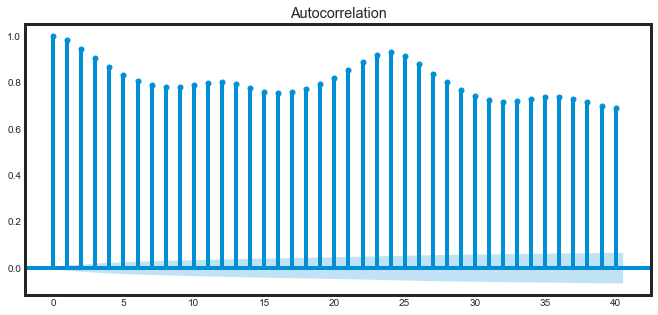

In [115]:
# Autocorrelation and partial auto-corelation plot

fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(data_ts.demand, ax=ax, lags= 40)
plt.show()

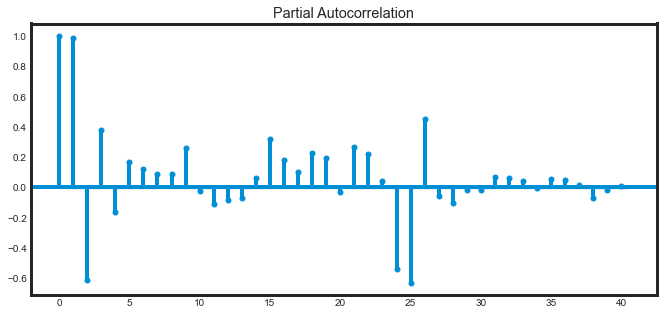

In [116]:
# Partial autocorrelation plot

fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_pacf(data_ts.demand, ax=ax, lags= 40)
plt.show()

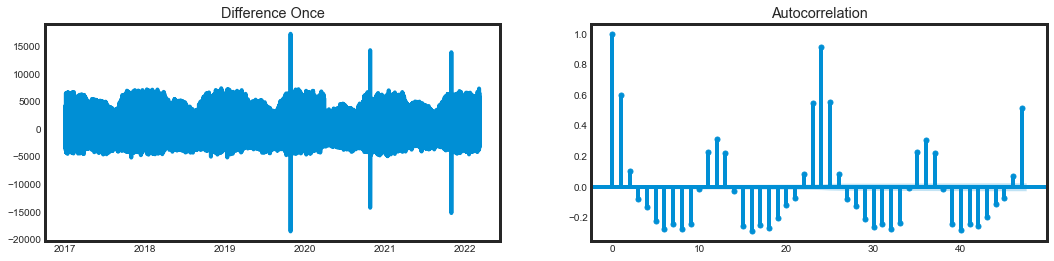

In [117]:
diff = data_ts.demand.diff().dropna()

fig, (ax1, ax2) = plt.subplots (1,2, figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax = ax2);

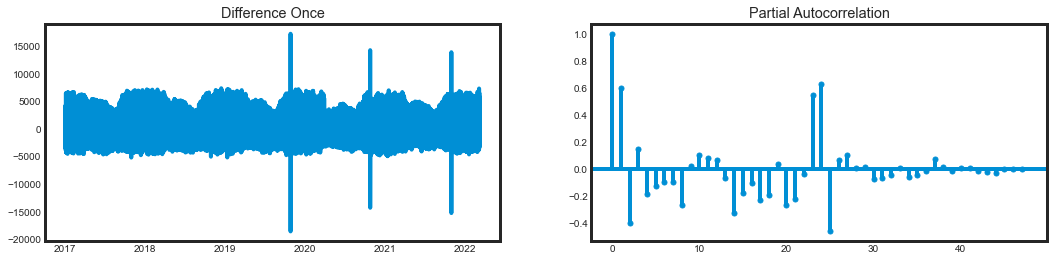

In [118]:
diff = data_ts.demand.diff().dropna()

fig, (ax1, ax2) = plt.subplots (1,2, figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
plot_pacf(diff, ax = ax2);

#### The pmdarima module helps us to identify the differentiation (d) value for applying ARIMA

In [119]:
from pmdarima.arima.utils import ndiffs

In [120]:
ndiffs(data_ts.demand, test = "adf")

0

#### The ACF and PACF plots are extremely crucial to get the q and p values respectively for the ARIMA model.
#### After carefully analysing the ACF and PACF plots along with some trial and error methods, I have concluded the values for (p,d,q) as (1,0,1) respectively.
#### Since the data follows a yearly cycle, the m value would be 12.

# SARIMAX

In [121]:
data_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45432 entries, 2017-01-01 00:00:00+01:00 to 2022-03-08 23:00:00+01:00
Freq: 60T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   demand  45432 non-null  int32
dtypes: int32(1)
memory usage: 1.5 MB


In [122]:
# Fit the model

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

results = sm.tsa.statespace.SARIMAX(data_ts['demand'],order=(1,0,1),seasonal_order=(1,0,1,12))

In [123]:
results_fit = results.fit()

C:\Users\ajeup\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [124]:
print(results_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             demand   No. Observations:                45432
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood             -385754.534
Date:                            Thu, 26 May 2022   AIC                         771519.068
Time:                                    16:59:14   BIC                         771562.688
Sample:                                01-01-2017   HQIC                        771532.793
                                     - 03-08-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9972      0.001    745.339      0.000       0.995       1.000
ma.L1          0.6614      0.001   

In [125]:
data_ts.index

DatetimeIndex(['2017-01-01 00:00:00+01:00', '2017-01-01 01:00:00+01:00',
               '2017-01-01 02:00:00+01:00', '2017-01-01 03:00:00+01:00',
               '2017-01-01 04:00:00+01:00', '2017-01-01 05:00:00+01:00',
               '2017-01-01 06:00:00+01:00', '2017-01-01 07:00:00+01:00',
               '2017-01-01 08:00:00+01:00', '2017-01-01 09:00:00+01:00',
               ...
               '2022-03-08 14:00:00+01:00', '2022-03-08 15:00:00+01:00',
               '2022-03-08 16:00:00+01:00', '2022-03-08 17:00:00+01:00',
               '2022-03-08 18:00:00+01:00', '2022-03-08 19:00:00+01:00',
               '2022-03-08 20:00:00+01:00', '2022-03-08 21:00:00+01:00',
               '2022-03-08 22:00:00+01:00', '2022-03-08 23:00:00+01:00'],
              dtype='datetime64[ns, tzoffset(None, 3600)]', name='Time', length=45432, freq='60T')

In [126]:
from math import sqrt

pred = results_fit.get_prediction(start= ('2017-01-01 00:00:00+01:00'), dynamic=False)

predicted = pred.predicted_mean
expected = data_ts['2017-01-01 00:00:00+01:00':]

In [127]:
MAE = mean_absolute_error(expected, predicted)
print('MAE : {}'.format(round(MAE, 2)))

MSE = mean_squared_error(expected, predicted)
print('Mean Squared Error : {}'.format(round(MSE, 2)))

RMSE = sqrt(MSE)
print('Root Mean Squared Error  : %f' % RMSE)

R2_SCORE=r2_score(expected, predicted)
print('R2_Score (Co-efficient of Determination)  : %f' % R2_SCORE)

print('Accuracy:',round(R2_SCORE*100,2),'%')

MAE : 853.68
Mean Squared Error : 1510325.48
Root Mean Squared Error  : 1228.953000
R2_Score (Co-efficient of Determination)  : 0.989170
Accuracy: 98.92 %


<AxesSubplot:ylabel='Density'>

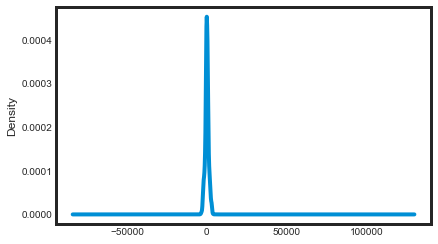

In [128]:
results_fit.resid.plot(kind='kde')

#### We see that the KDE plot has a peak at 0, which shows that there is very less bias in the prediction

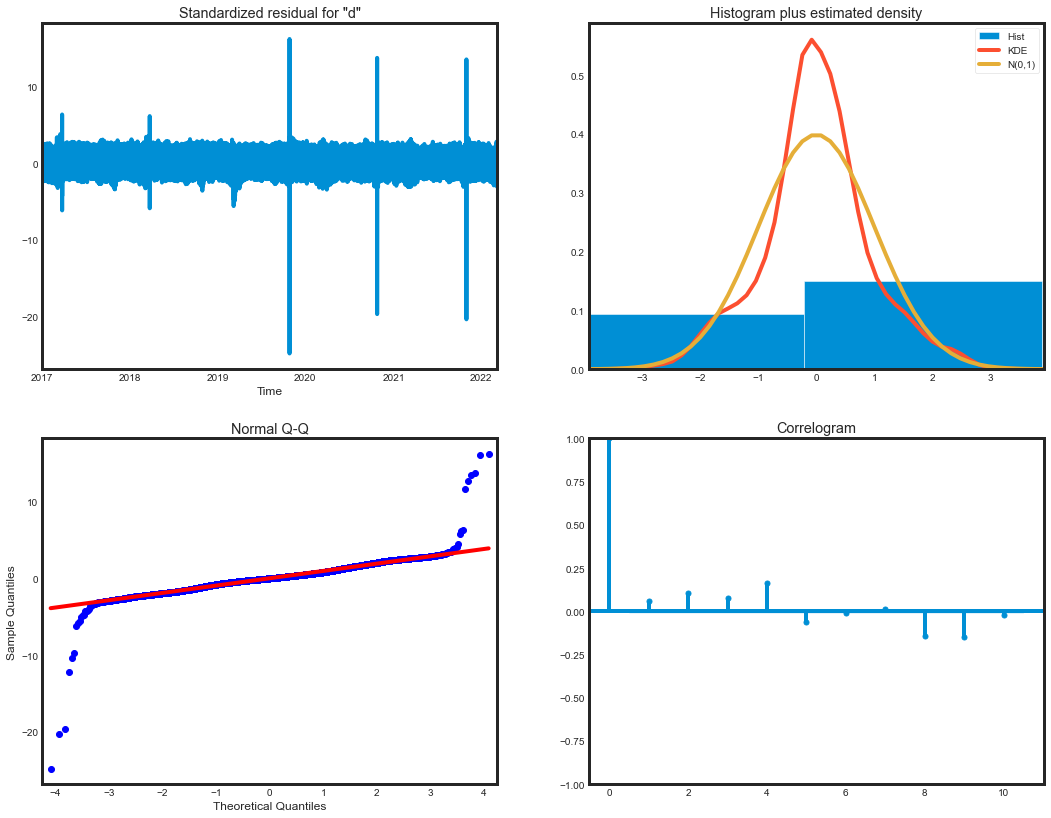

In [129]:
results_fit.plot_diagnostics(figsize=(16, 14))
plt.show()

#### At the top left corner, the standardized residuals move around a mean of zero. The bottom left charts a correlation which shows a normal distribution all along the red line The top-right plot is a histogram plus estimated density plot, it should ideally show a histogram occurring normally at 0, while here in the figure, it does not do so. Lastly, the bottom right graph is a Correlogram which generally depicts the randomness in a dataset. If the values are closer to zero, it means that the data has very less randomness. In this case, it is between the range of (-0.2) to (0.2), so there is room for improvement.

## Validating forecasts

#### First, we try to forecast accurately with the given data to see if the forecast and real data match.

<AxesSubplot:xlabel='Time'>

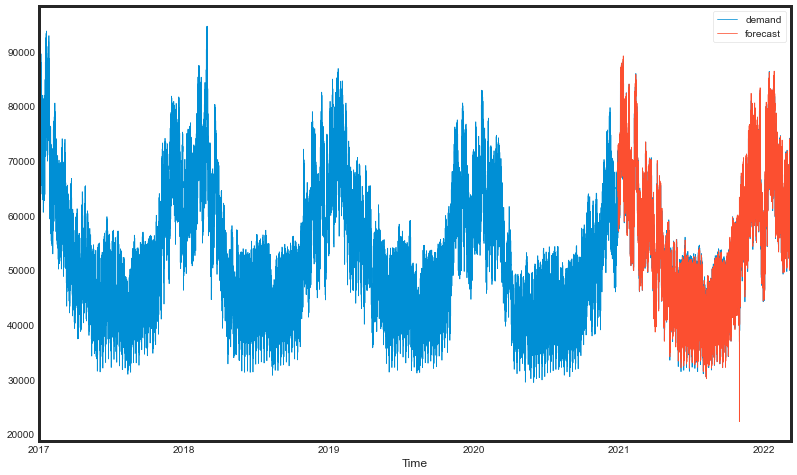

In [130]:
data_ts['forecast'] = results_fit.predict(start = 35000, end = 45433)
data_ts[['demand','forecast']].plot(figsize=(12,8), linewidth = 0.75)

In [131]:
from pandas.tseries.offsets import DateOffset
future_dates = [data_ts.index[-1]+ DateOffset(hours = x)for x in range (0,49)]

In [132]:
future_hours = pd.DataFrame(index = future_dates [1:], columns = data_ts.columns)

In [133]:
future_hours.tail()

,demand,forecast
2022-03-10 19:00:00+01:00,NaN,NaN
2022-03-10 20:00:00+01:00,NaN,NaN
2022-03-10 21:00:00+01:00,NaN,NaN
2022-03-10 22:00:00+01:00,NaN,NaN
2022-03-10 23:00:00+01:00,NaN,NaN


In [134]:
future_forecast = pd.concat([data_ts,future_hours])

<AxesSubplot:>

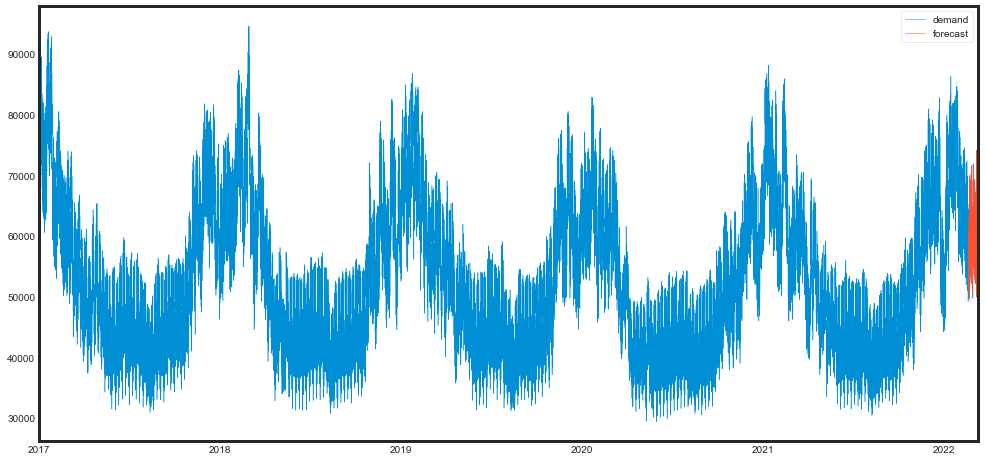

In [135]:
future_forecast['forecast'] = results_fit.predict(start = 45000, end = 45482)
future_forecast[['demand','forecast']].plot(figsize=(15,8), linewidth = 0.5) 


### To get a better view of the future forecasted plot, we will focus on the latest dates alone 

In [136]:
future_forecast.tail(50)

,demand,forecast
2022-03-08 22:00:00+01:00,63364,63398.291898
2022-03-08 23:00:00+01:00,63996,63293.468264
2022-03-09 00:00:00+01:00,NaN,63578.744559
2022-03-09 01:00:00+01:00,NaN,61683.201158
2022-03-09 02:00:00+01:00,NaN,59922.662323
2022-03-09 03:00:00+01:00,NaN,57805.337866
2022-03-09 04:00:00+01:00,NaN,56772.632212
2022-03-09 05:00:00+01:00,NaN,58009.113590
2022-03-09 06:00:00+01:00,NaN,62295.038029
2022-03-09 07:00:00+01:00,NaN,66881.937998


<AxesSubplot:>

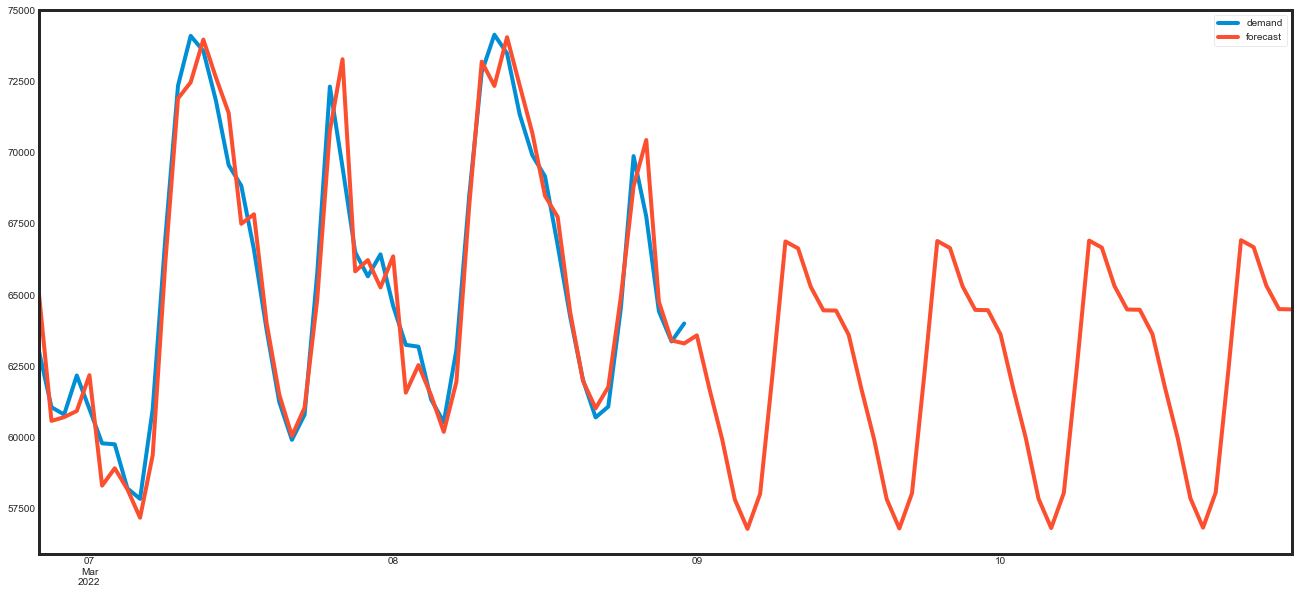

In [137]:
future_forecast.tail(100).plot(figsize = (20,10))


## Thus we are able to forecast 48 hours into the future to get the electricity demand using the SARIMA time series model with 98.92% accuracy

# Results

| Total Algorithms Used         | Accuracy |
|-------------------------------|----------|
| ARIMA (1,0,1) (1,0,1,12)      | 98.92%   |
| XGBoost Regressor             | 97.53%   |          
| Random Forest Regressor       | 96.62%   |
| K Nearest Neighbors Regressor | 95.06%   |
| Decision Tree Regressor       | 92.90%   |
| AdaBoost Regressor            | 82.90%   |
| Linear Regression             | 72.20%   |

## Conclusion: 

### 1. We can see that Seasonal ARIMA has the highest accuracy of 98.92% and is best suited for this dataset compared to the other algorithms used.

### 2. Temperature data is also available in the given dataset and it would be really interesting to add temperature as an predictor. However, to do so I believe would not be correct as we do not know the future temperature. Nevertheless, if needed, we can do so by training the model on the forecasted temperature rather than the actual temperature. Multivariate Time series analysis can be done using Vector Auto Regression (VAR).